## Purpose of this script is to create features to be used in model creation 

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import time
import datetime
%matplotlib inline

Load data from processed dataset

In [23]:
matches_raw = pd.read_csv('/Users/mtetkosk/Google Drive/Data Science Projects/data/processed/EPL_Matches_Reduced.csv')

matches=matches_raw.copy()
print len(matches)
print matches.shape

3040
(3040, 27)


In [24]:
matches.head()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
0,1729,2008/2009,1,8/17/08 0:00,489042,10260,10261,1,1,1.29,...,8.50,1.25,4.5,10.00,1.25,4.5,10.00,1.28,5.5,12.00
1,1730,2008/2009,1,8/16/08 0:00,489043,9825,8659,1,0,1.20,...,11.00,1.20,5.0,11.00,1.17,5.5,12.00,1.25,6.0,13.00
2,1731,2008/2009,1,8/16/08 0:00,489044,8472,8650,0,1,5.50,...,1.65,4.50,3.3,1.67,5.50,3.3,1.57,5.50,3.8,1.65
3,1732,2008/2009,1,8/16/08 0:00,489045,8654,8528,2,1,1.91,...,3.80,1.80,3.2,4.00,1.83,3.2,3.75,1.90,3.5,4.35
4,1733,2008/2009,1,8/17/08 0:00,489046,10252,8456,4,2,1.91,...,3.30,1.83,3.2,3.75,1.91,3.2,3.50,1.90,3.5,4.35


First job is to create a target variable.

There are 3 possible outcomes:
- Home Win
- Away Win
- Draw

In [25]:
matches['Result_Target'] = np.nan

In [26]:
multiclass = False  # Use this to set the target variables

In [27]:
if multiclass:
    matches.ix[matches['home_team_goal'] > matches['away_team_goal'], 'Result_Target'] = 1
    matches.ix[matches['home_team_goal'] < matches['away_team_goal'], 'Result_Target'] = -1
    matches.ix[matches['home_team_goal'] == matches['away_team_goal'], 'Result_Target'] = 0
else:
    matches.ix[matches['home_team_goal'] > matches['away_team_goal'], 'Result_Target'] = 1
    matches.ix[matches['home_team_goal'] < matches['away_team_goal'], 'Result_Target'] = 0
    matches.ix[matches['home_team_goal'] == matches['away_team_goal'], 'Result_Target'] = 0    

0.0    1229
1.0    1051
Name: Result_Target, dtype: int64


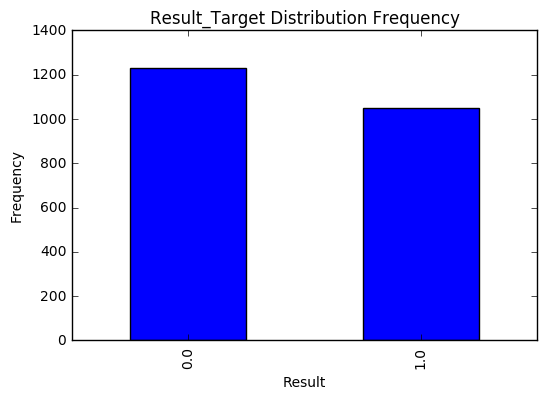

In [108]:
matches['Result_Target'].value_counts().plot(kind = 'bar')
plt.xlabel('Result')
plt.ylabel('Frequency')
plt.title('Result_Target Distribution Frequency')
print matches['Result_Target'].value_counts()

In [29]:
matches.head()  # Sanity check that the results column makes sense - Looks Ok!

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA,Result_Target
0,1729,2008/2009,1,8/17/08 0:00,489042,10260,10261,1,1,1.29,...,1.25,4.5,10.00,1.25,4.5,10.00,1.28,5.5,12.00,0.0
1,1730,2008/2009,1,8/16/08 0:00,489043,9825,8659,1,0,1.20,...,1.20,5.0,11.00,1.17,5.5,12.00,1.25,6.0,13.00,1.0
2,1731,2008/2009,1,8/16/08 0:00,489044,8472,8650,0,1,5.50,...,4.50,3.3,1.67,5.50,3.3,1.57,5.50,3.8,1.65,0.0
3,1732,2008/2009,1,8/16/08 0:00,489045,8654,8528,2,1,1.91,...,1.80,3.2,4.00,1.83,3.2,3.75,1.90,3.5,4.35,1.0
4,1733,2008/2009,1,8/17/08 0:00,489046,10252,8456,4,2,1.91,...,1.83,3.2,3.75,1.91,3.2,3.50,1.90,3.5,4.35,1.0


### Feature Creation Step

The function below returns 3 dictionaries for each season:
     - Team Standings
     - Team Goal Difference
     - Team Results String (win, loss, draw)

In [30]:
def SeasonStanding(season):
    
    stages = range(1,39)
    
    points_dict = {}
    goal_diff = {}
    stage_dict = {}
    goal_diff_stage = {}
    team_results = {}
    
    for stage in stages:
        
        sub = season[season['stage']==stage]
        sub = sub.reset_index(drop = True)

        for i in range(len(sub)):
            
            home_goal = sub['home_team_goal'][i]
            away_goal = sub['away_team_goal'][i]
                
            if home_goal > away_goal:  ## home_win
                
                # Points
                if sub['home_team_api_id'][i] in points_dict.keys():
                    points_dict[sub['home_team_api_id'][i]] +=3
                else:
                    points_dict[sub['home_team_api_id'][i]] = 3
                if sub['away_team_api_id'][i] not in points_dict.keys():
                    points_dict[sub['away_team_api_id'][i]] = 0
                
                # Results
                
                if sub['home_team_api_id'][i] in team_results.keys():
                    team_results[sub['home_team_api_id'][i]].append('Win')
                else:
                    team_results[sub['home_team_api_id'][i]] = ['Win'] 
                    
                if sub['away_team_api_id'][i] in team_results.keys():
                    team_results[sub['away_team_api_id'][i]].append('Loss')
                else:
                    team_results[sub['away_team_api_id'][i]] = ['Loss']
                    
                    
                
                # Goal Difference
                if sub['home_team_api_id'][i] in goal_diff.keys():
                    goal_diff[sub['home_team_api_id'][i]] += home_goal - away_goal
                else:
                    goal_diff[sub['home_team_api_id'][i]] = home_goal - away_goal
                    
                if sub['away_team_api_id'][i] in goal_diff.keys():
                    goal_diff[sub['away_team_api_id'][i]] += away_goal - home_goal
                else:
                    goal_diff[sub['away_team_api_id'][i]] = away_goal - home_goal
                    
                continue

            if home_goal < away_goal:  ## away_win
                # Points
                if sub['away_team_api_id'][i] in points_dict.keys():
                    points_dict[sub['away_team_api_id'][i]] +=3
                else:
                    points_dict[sub['away_team_api_id'][i]] =3 
                if sub['home_team_api_id'][i] not in points_dict.keys():
                    points_dict[sub['home_team_api_id'][i]] = 0
                    
                # Results   
                if sub['home_team_api_id'][i] in team_results.keys():
                    team_results[sub['home_team_api_id'][i]].append('Loss')
                else:
                    team_results[sub['home_team_api_id'][i]] = ['Loss'] 
                    
                if sub['away_team_api_id'][i] in team_results.keys():
                    team_results[sub['away_team_api_id'][i]].append('Win')
                else:
                    team_results[sub['away_team_api_id'][i]] = ['Win']
                
                # Goal Difference 
                if sub['home_team_api_id'][i] in goal_diff.keys():
                    goal_diff[sub['home_team_api_id'][i]] += home_goal - away_goal
                else:
                    goal_diff[sub['home_team_api_id'][i]] = home_goal - away_goal
                    
                if sub['away_team_api_id'][i] in goal_diff.keys():
                    goal_diff[sub['away_team_api_id'][i]] += away_goal - home_goal
                else:
                    goal_diff[sub['away_team_api_id'][i]] = away_goal - home_goal 
                    
                    
                continue

            if sub['home_team_goal'][i] == sub['away_team_goal'][i]:
                # Points
                if sub['away_team_api_id'][i] in points_dict.keys():
                    points_dict[sub['away_team_api_id'][i]] +=1
                else:
                    points_dict[sub['away_team_api_id'][i]] = 1     
                if sub['home_team_api_id'][i] in points_dict.keys():
                    points_dict[sub['home_team_api_id'][i]] +=1
                else:
                    points_dict[sub['home_team_api_id'][i]] =1  
                    
                # Results   
                if sub['home_team_api_id'][i] in team_results.keys():
                    team_results[sub['home_team_api_id'][i]].append('Draw')
                else:
                    team_results[sub['home_team_api_id'][i]] = ['Draw'] 
                    
                if sub['away_team_api_id'][i] in team_results.keys():
                    team_results[sub['away_team_api_id'][i]].append('Draw')
                else:
                    team_results[sub['away_team_api_id'][i]] = ['Draw']
                
                # Initialize Goal Difference if Needed
                
                if sub['away_team_api_id'][i] not in goal_diff.keys():
                    goal_diff[sub['away_team_api_id'][i]] = 0
                if sub['home_team_api_id'][i] not in goal_diff.keys():
                    goal_diff[sub['home_team_api_id'][i]] = 0                

        s_data = sorted(points_dict.items(), key=lambda item: item[1])
        rank, count, previous, result = 0, 0, None, {}
    
        for key, num in s_data:
            count += 1
            if num != previous:
                rank += count
                previous = num
                count = 0
            result[key] = 21-rank

        stage_dict[stage] = result.copy()
        goal_diff_stage[stage] = goal_diff.copy()

        
    return stage_dict, goal_diff_stage,team_results

In [31]:
def LastKResults(team, stage, results_list,k):
    
    if (stage-1)-k >= 0:
        results = results_list[(stage-1)-k:stage-1]
        wins_count = results.count('Win')
        loss_count = results.count('Loss')
        draw_count = results.count('Draw')
  
        return wins_count, loss_count, draw_count   

    else:
        wins_count = -1
        loss_count = -1
        draw_count = -1
        
        return wins_count, loss_count, draw_count
    


## Season Stats

In [32]:
def CreateSeasonStats(df_in,last_k):
    
    df = df_in.copy()  #make a copy of the input data to avoid setting copy on df slices
    
    seasons = list(matches['season'].unique())
    
    # set up master dictionaries
    season_standings = {}
    season_goal_difference = {}
    season_results = {}
    
    for season in seasons: # iterate thru seasons and append to master dictionaries
        subset = df[df['season']==season]
        standings, goal_difference, results = SeasonStanding(subset)
        season_standings[season] = standings
        season_goal_difference[season] = goal_difference
        season_results[season] = results
    
    home_team_standing = []
    away_team_standing = []
    
    home_team_goal_diff = []
    away_team_goal_diff = []
    
    home_dict = {}
    away_dict = {}
    

    for i in range(len(df)):
        home_team = df['home_team_api_id'][i]
        away_team = df['away_team_api_id'][i]
        stage = df['stage'][i]
        season = df['season'][i]
        
        # Always lookup values for stage-1 because you cannot append values of the current game week. Always looking up to 1 week prior
        # Standings Lookup
        if stage == 1:
            home_team_standing.append(-1)
        else:
            hts = season_standings[season][stage-1][home_team]
            home_team_standing.append(hts)
        
        if stage == 1:
            away_team_standing.append(-1)
        else:
            ats = season_standings[season][stage-1][away_team]
            away_team_standing.append(ats)
        
        # Goal Difference Lookup
        if stage == 1:
            home_team_goal_diff.append(0)
        else:
            hgd = season_goal_difference[season][stage-1][home_team]
            home_team_goal_diff.append(hgd)
        
        if stage == 1:
            away_team_goal_diff.append(0)
        else:
            agd = season_goal_difference[season][stage-1][away_team]
            away_team_goal_diff.append(agd)
        
        # Last K Results
        
        home_team_results_list = season_results[season][home_team]
        away_team_results_list = season_results[season][away_team]
        
        last_k_range = range(1,last_k)   
        
        for k_val in last_k_range:
            hwc,hlc,hdc = LastKResults(home_team,stage,home_team_results_list,k_val)
            awc,alc,adc = LastKResults(away_team,stage,away_team_results_list,k_val)
                        
            if k_val not in home_dict.keys():
                home_dict[k_val] = {'Wins' : [hwc],'Draws' : [hdc],'Losses':[hlc]}
                away_dict[k_val] = {'Wins' : [awc],'Draws' : [adc], 'Losses':[alc]}
            else:
                home_dict[k_val]['Wins'].append(hwc)
                home_dict[k_val]['Draws'].append(hdc)
                home_dict[k_val]['Losses'].append(hlc)
                
                away_dict[k_val]['Wins'].append(awc)
                away_dict[k_val]['Draws'].append(adc)
                away_dict[k_val]['Losses'].append(alc)                
                
            
    for val in home_dict.keys():
        df['Home_Team_Last_%d_Wins'%(val)] = home_dict[val]['Wins']
        df['Home_Team_Last_%d_Draws'%(val)] = home_dict[val]['Draws']
        df['Home_Team_Last_%d_Losses'%(val)] = home_dict[val]['Losses']
        
        df['Away_Team_Last_%d_Wins'%(val)] = away_dict[val]['Wins']
        df['Away_Team_Last_%d_Draws'%(val)] = away_dict[val]['Draws']
        df['Away_Team_Last_%d_Losses'%(val)] = away_dict[val]['Losses']
              
    df['Home_Standing'] = home_team_standing
    df['Away_Standing'] = away_team_standing
    df['Home_Goal_Diff'] = home_team_goal_diff
    df['Away_Goal_Diff'] = away_team_goal_diff
    df['Standing_Diff'] = df['Home_Standing']- df['Away_Standing']
    df['Diff_Goal_Diff'] = df['Home_Goal_Diff'] - df['Away_Goal_Diff']
        
    return df

In [33]:
matches = CreateSeasonStats(matches,10)
matches.head(30)

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,...,Home_Team_Last_9_Losses,Away_Team_Last_9_Wins,Away_Team_Last_9_Draws,Away_Team_Last_9_Losses,Home_Standing,Away_Standing,Home_Goal_Diff,Away_Goal_Diff,Standing_Diff,Diff_Goal_Diff
0,1729,2008/2009,1,8/17/08 0:00,489042,10260,10261,1,1,1.29,...,-1,-1,-1,-1,-1,-1,0,0,0,0
1,1730,2008/2009,1,8/16/08 0:00,489043,9825,8659,1,0,1.20,...,-1,-1,-1,-1,-1,-1,0,0,0,0
2,1731,2008/2009,1,8/16/08 0:00,489044,8472,8650,0,1,5.50,...,-1,-1,-1,-1,-1,-1,0,0,0,0
3,1732,2008/2009,1,8/16/08 0:00,489045,8654,8528,2,1,1.91,...,-1,-1,-1,-1,-1,-1,0,0,0,0
4,1733,2008/2009,1,8/17/08 0:00,489046,10252,8456,4,2,1.91,...,-1,-1,-1,-1,-1,-1,0,0,0,0
5,1734,2008/2009,1,8/16/08 0:00,489047,8668,8655,2,3,2.00,...,-1,-1,-1,-1,-1,-1,0,0,0,0
6,1735,2008/2009,1,8/16/08 0:00,489048,8549,8586,2,1,3.20,...,-1,-1,-1,-1,-1,-1,0,0,0,0
7,1736,2008/2009,1,8/16/08 0:00,489049,8559,10194,3,1,1.83,...,-1,-1,-1,-1,-1,-1,0,0,0,0
8,1737,2008/2009,1,8/16/08 0:00,489050,8667,9879,2,1,2.60,...,-1,-1,-1,-1,-1,-1,0,0,0,0
9,1738,2008/2009,1,8/17/08 0:00,489051,8455,8462,4,0,1.33,...,-1,-1,-1,-1,-1,-1,0,0,0,0


##### Aggregated Odds - Average

In [34]:
## Betting Odds Columns
odds = matches[matches.columns[9:27]].copy()
odds.head()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
0,1.29,5.5,11.00,1.30,4.75,8.25,1.3,4.4,8.50,1.25,4.5,10.00,1.25,4.5,10.00,1.28,5.5,12.00
1,1.20,6.5,15.00,1.22,5.50,10.00,1.2,5.2,11.00,1.20,5.0,11.00,1.17,5.5,12.00,1.25,6.0,13.00
2,5.50,3.6,1.67,5.00,3.35,1.67,4.5,3.5,1.65,4.50,3.3,1.67,5.50,3.3,1.57,5.50,3.8,1.65
3,1.91,3.4,4.20,1.90,3.20,3.80,1.8,3.3,3.80,1.80,3.2,4.00,1.83,3.2,3.75,1.90,3.5,4.35
4,1.91,3.4,4.33,1.95,3.20,3.60,2.0,3.2,3.30,1.83,3.2,3.75,1.91,3.2,3.50,1.90,3.5,4.35


In [35]:
home_odds = []
away_odds = []
draw_odds = []

for colname in odds.columns:
    if colname in ['WHH','WHD','WHA']:
        if colname == 'WHH':
            home_odds.append(colname)
        elif colname == 'WHD':
            draw_odds.append(colname)
        elif colname == 'WHA':
            away_odds.append(colname)
        continue
    if 'H' in colname:
        home_odds.append(colname)
    elif 'A' in colname:
        away_odds.append(colname)
    else:
        draw_odds.append(colname)

In [36]:
# Fill null values with the average of each row

matches['BWH'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['IWH'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['LBH'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['BWD'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['IWD'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['LBD'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['BWA'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['IWA'].fillna(odds[home_odds].mean(axis=1),inplace = True)
matches['LBA'].fillna(odds[home_odds].mean(axis=1),inplace = True)


In [39]:
matches['Average_Home_Odds'] = odds[home_odds].mean(axis=1).round(2)
matches['Average_Away_Odds'] = odds[away_odds].mean(axis=1).round(2)
matches['Average_Draw_Odds'] = odds[draw_odds].mean(axis=1).round(2)

In [40]:
## Remove extra betting columns

del matches['BWH']
del matches['IWH']
del matches['LBH']
del matches['BWD']
del matches['IWD']
del matches['LBD']
del matches['BWA']
del matches['IWA']
del matches['LBA']
del matches['B365H']
del matches['B365A']
del matches['B365D']
del matches['WHH']
del matches['WHD']
del matches['WHA']
del matches['VCH']
del matches['VCD']
del matches['VCA']


In [41]:
matches.columns

Index([u'id', u'season', u'stage', u'date', u'match_api_id',
       u'home_team_api_id', u'away_team_api_id', u'home_team_goal',
       u'away_team_goal', u'Result_Target', u'Home_Team_Last_1_Wins',
       u'Home_Team_Last_1_Draws', u'Home_Team_Last_1_Losses',
       u'Away_Team_Last_1_Wins', u'Away_Team_Last_1_Draws',
       u'Away_Team_Last_1_Losses', u'Home_Team_Last_2_Wins',
       u'Home_Team_Last_2_Draws', u'Home_Team_Last_2_Losses',
       u'Away_Team_Last_2_Wins', u'Away_Team_Last_2_Draws',
       u'Away_Team_Last_2_Losses', u'Home_Team_Last_3_Wins',
       u'Home_Team_Last_3_Draws', u'Home_Team_Last_3_Losses',
       u'Away_Team_Last_3_Wins', u'Away_Team_Last_3_Draws',
       u'Away_Team_Last_3_Losses', u'Home_Team_Last_4_Wins',
       u'Home_Team_Last_4_Draws', u'Home_Team_Last_4_Losses',
       u'Away_Team_Last_4_Wins', u'Away_Team_Last_4_Draws',
       u'Away_Team_Last_4_Losses', u'Home_Team_Last_5_Wins',
       u'Home_Team_Last_5_Draws', u'Home_Team_Last_5_Losses',
       

In [42]:
matches.head()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Result_Target,...,Away_Team_Last_9_Losses,Home_Standing,Away_Standing,Home_Goal_Diff,Away_Goal_Diff,Standing_Diff,Diff_Goal_Diff,Average_Home_Odds,Average_Away_Odds,Average_Draw_Odds
0,1729,2008/2009,1,8/17/08 0:00,489042,10260,10261,1,1,0.0,...,-1,-1,-1,0,0,0,0,1.28,9.96,4.86
1,1730,2008/2009,1,8/16/08 0:00,489043,9825,8659,1,0,1.0,...,-1,-1,-1,0,0,0,0,1.21,12.00,5.62
2,1731,2008/2009,1,8/16/08 0:00,489044,8472,8650,0,1,0.0,...,-1,-1,-1,0,0,0,0,5.08,1.65,3.48
3,1732,2008/2009,1,8/16/08 0:00,489045,8654,8528,2,1,1.0,...,-1,-1,-1,0,0,0,0,1.86,3.98,3.30
4,1733,2008/2009,1,8/17/08 0:00,489046,10252,8456,4,2,1.0,...,-1,-1,-1,0,0,0,0,1.92,3.80,3.28


All columns look ok! Let's finally check and make sure there are no NAN values

In [43]:
null_dict = {}

for col in matches.columns:
    nulls = matches[col].isnull().sum()
    if nulls > 0:
        null_dict[col] = nulls

null_dict

{}

##### Last K-Goals

This feature will create 4 new features
- Home_Team_Last_K_Scored
- Home_Team_Last_K_Conceded
- Away_Team_Last_K_Scored
- Away_Team_Last_K_Conceded

Games where last k value cannot be calculated, attribute will be imputed with -1

In [44]:
def LastKGoals(season_df,k):
    
    
    ## Function output:
    ##  DataFrame {match_api_id, home_team_last_k_scored , home_team_last_k_conceded, away_team_last_k_scored, away_team_last_k_conceded}
    
    home_team_last_k_scored = []
    home_team_last_k_conceded = []
    away_team_last_k_scored = []
    away_team_last_k_conceded = []
    match_api_id = []
    
    for i in range(1,39):
        # if last-k metric cannot be computed, impute with -1
        if i <= k:
            subset = season_df[season_df['stage'] == i]
            match_id = subset['match_api_id'].tolist()
            match_api_id.extend(match_id)
            
            # Impute values of -1 where last-k metric cannot be computed
            home_team_last_k_scored.extend([-1]*10)
            home_team_last_k_conceded.extend([-1]*10)
            away_team_last_k_scored.extend([-1]*10)
            away_team_last_k_conceded.extend([-1]*10)
            
            continue       

        #create subset of games in the k-stages before
        subset = season_df[season_df['stage'] >= i-k]
        subset = subset[subset['stage'] < i]
        
        cur_stage = season_df[season_df['stage'] == i]
        
        home_teams = cur_stage['home_team_api_id'].tolist()
        away_teams = cur_stage['away_team_api_id'].tolist()
        match_api_id.extend(cur_stage['match_api_id'].tolist())
        
        for team in home_teams:
            prev_home = subset[subset['home_team_api_id'] == team]
            prev_away = subset[subset['away_team_api_id'] == team]
            
            #last-k-scored
            prev_home_scored = prev_home['home_team_goal'][subset['home_team_api_id'] == team].tolist()
            prev_away_scored = prev_away['away_team_goal'][subset['away_team_api_id'] == team].tolist()
            #last-k-conceded
            prev_home_conceded = prev_home['away_team_goal'][subset['home_team_api_id'] == team].tolist()
            prev_away_conceded = prev_away['home_team_goal'][subset['away_team_api_id'] == team].tolist()            
            
            home_team_last_k_scored.append(sum(prev_home_scored)+sum(prev_away_scored))
            home_team_last_k_conceded.append(sum(prev_home_conceded)+sum(prev_away_conceded))
            
        for team in away_teams:
            prev_home = subset[subset['home_team_api_id'] == team]
            prev_away = subset[subset['away_team_api_id'] == team]
            
            #last-k-scored
            prev_home_scored = prev_home['home_team_goal'][subset['home_team_api_id'] == team].tolist()
            prev_away_scored = prev_away['away_team_goal'][subset['away_team_api_id'] == team].tolist()
            #last-k-conceded
            prev_home_conceded = prev_home['away_team_goal'][subset['home_team_api_id'] == team].tolist()
            prev_away_conceded = prev_away['home_team_goal'][subset['away_team_api_id'] == team].tolist()            
            
            away_team_last_k_scored.append(sum(prev_home_scored)+sum(prev_away_scored))
            away_team_last_k_conceded.append(sum(prev_home_conceded)+sum(prev_away_conceded))
    
    last_k_df = pd.DataFrame({'home_team_last_k_scored':home_team_last_k_scored,\
                                  'home_team_last_k_conceded': home_team_last_k_conceded,\
                                  'away_team_last_k_scored': away_team_last_k_scored,\
                                  'away_team_last_k_conceded':away_team_last_k_conceded,\
                                  'match_api_id':match_api_id})
    
    
    
    return last_k_df

In [45]:
def CreateLastKFeature(df,lastk):
    seasons = df['season'].unique()
    
    count = 0
    
    for year in seasons:
    
        matches_season = matches[matches['season'] == year]
    
        last_k_goals_df = LastKGoals(matches_season,lastk)
    
        if count == 0:
            home_k_scored = last_k_goals_df['home_team_last_k_scored'].tolist()
            home_k_conceded = last_k_goals_df['home_team_last_k_conceded'].tolist()
            away_k_scored = last_k_goals_df['away_team_last_k_scored'].tolist()
            away_k_conceded = last_k_goals_df['away_team_last_k_conceded'].tolist()
            match_id = last_k_goals_df['match_api_id'].tolist()
        else:
            home_k_scored.extend(last_k_goals_df['home_team_last_k_scored'].tolist())
            home_k_conceded.extend(last_k_goals_df['home_team_last_k_conceded'].tolist())
            away_k_scored.extend(last_k_goals_df['away_team_last_k_scored'].tolist())
            away_k_conceded.extend(last_k_goals_df['away_team_last_k_conceded'].tolist())
            match_id.extend(last_k_goals_df['match_api_id'].tolist())
    
        count += 1
        
        last_k_df = pd.DataFrame({'home_last_%d_scored'%(lastk):home_k_scored,\
                          'home_last_%d_conceded'%(lastk): home_k_conceded,\
                          'away_last_%d_scored'%(lastk): away_k_scored,\
                          'away_last_%d_concede'%(lastk): away_k_conceded,\
                          'match_api_id': match_id})
        
        
    return last_k_df
        
    

In [46]:
## Create features for k = 2,3,4,5

start = time.time()
for k_value in range(2,6):
    matches = matches.merge(CreateLastKFeature(matches,k_value), how='inner', on = 'match_api_id')

end = time.time()

diff = end-start

print 'Adding new k features took ' + str(round(diff,2)) + ' seconds'
print matches.shape

Adding new k features took 162.23 seconds
(3040, 89)


In [47]:
matches.tail()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Result_Target,...,home_last_3_conceded,home_last_3_scored,away_last_4_concede,away_last_4_scored,home_last_4_conceded,home_last_4_scored,away_last_5_concede,away_last_5_scored,home_last_5_conceded,home_last_5_scored
3035,4764,2015/2016,9,10/17/15 0:00,1988795,8466,8197,2,2,0.0,...,5,8,10,9,5,8,11,10,5,11
3036,4765,2015/2016,9,10/19/15 0:00,1988796,10003,10194,0,1,0.0,...,5,3,5,5,6,3,6,5,7,5
3037,4766,2015/2016,9,10/17/15 0:00,1988797,8586,8650,0,0,0.0,...,3,7,7,6,3,8,10,6,3,8
3038,4767,2015/2016,9,10/17/15 0:00,1988798,9817,9825,0,3,0.0,...,3,3,4,10,3,4,4,11,5,4
3039,4768,2015/2016,9,10/17/15 0:00,1988799,8659,8472,1,0,1.0,...,5,3,8,2,5,3,10,4,5,4


Lets check the results and make sure there aren't any missing values

In [48]:
null_dict = {}

for col in matches.columns:
    nulls = matches[col].isnull().sum()
    if nulls > 0:
        null_dict[col] = nulls

null_dict

{}

Great! There aren't any nulls

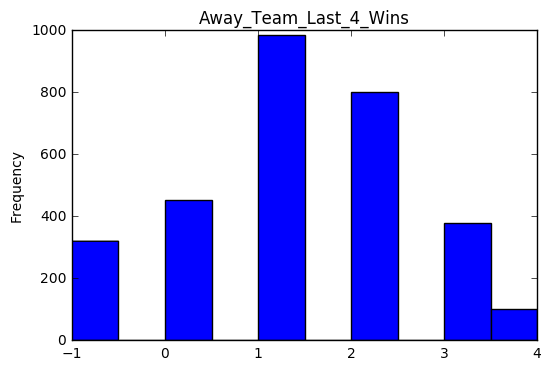

 1    984
 2    802
 0    453
 3    378
-1    320
 4    103
Name: Away_Team_Last_4_Wins, dtype: int64


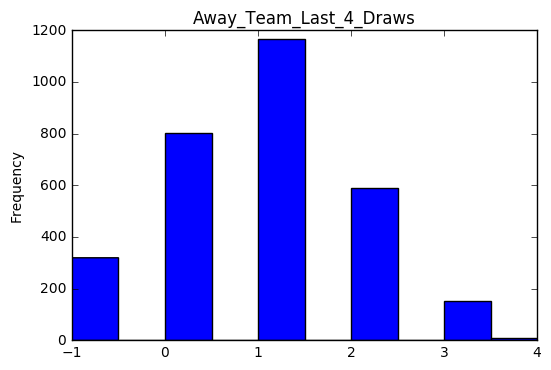

 1    1166
 0     802
 2     591
-1     320
 3     151
 4      10
Name: Away_Team_Last_4_Draws, dtype: int64


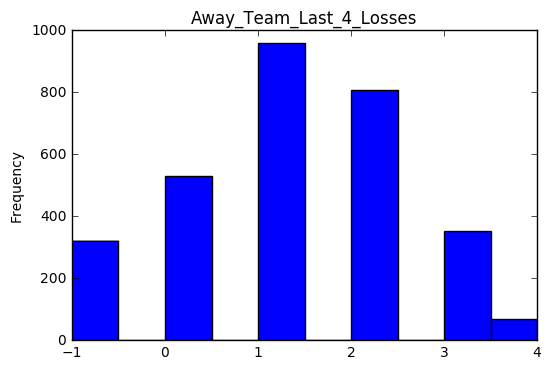

 1    961
 2    808
 0    531
 3    352
-1    320
 4     68
Name: Away_Team_Last_4_Losses, dtype: int64


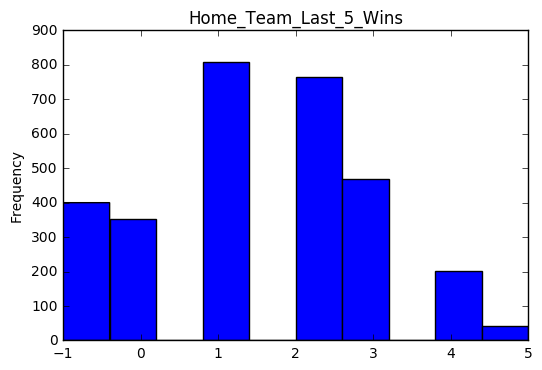

 1    807
 2    765
 3    470
-1    400
 0    353
 4    202
 5     43
Name: Home_Team_Last_5_Wins, dtype: int64


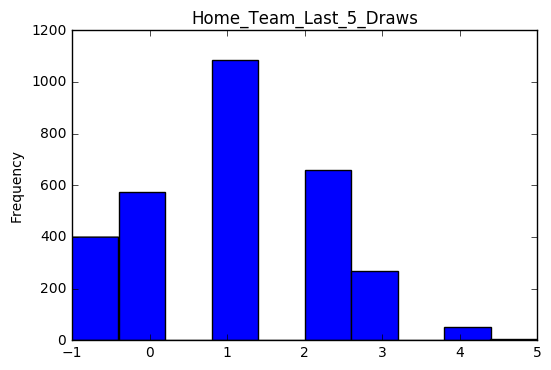

 1    1084
 2     660
 0     573
-1     400
 3     268
 4      51
 5       4
Name: Home_Team_Last_5_Draws, dtype: int64


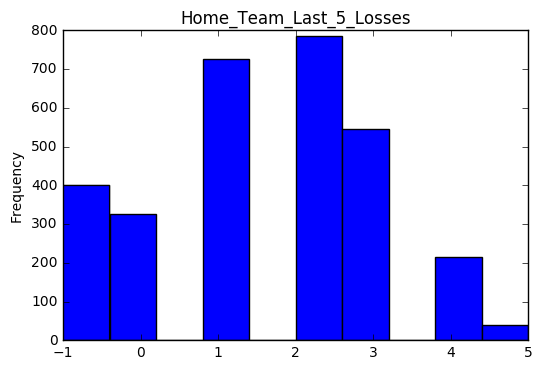

 2    786
 1    726
 3    545
-1    400
 0    327
 4    215
 5     41
Name: Home_Team_Last_5_Losses, dtype: int64


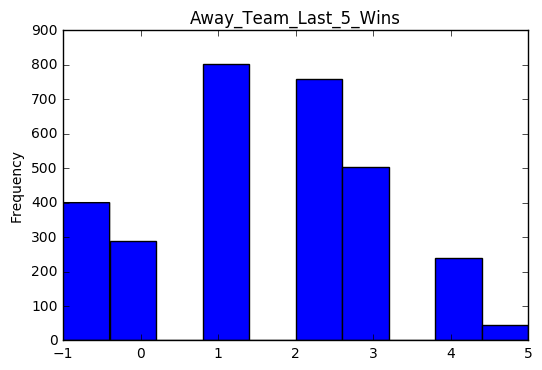

 1    804
 2    759
 3    504
-1    400
 0    290
 4    239
 5     44
Name: Away_Team_Last_5_Wins, dtype: int64


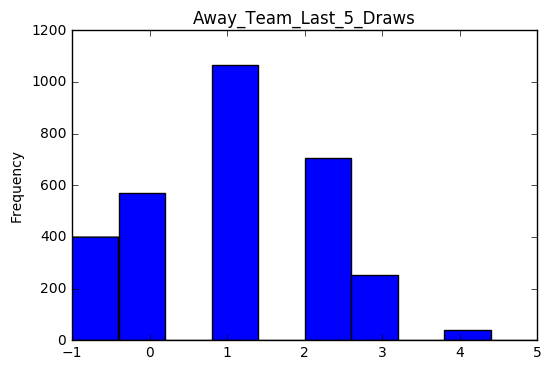

 1    1068
 2     707
 0     571
-1     400
 3     252
 4      40
 5       2
Name: Away_Team_Last_5_Draws, dtype: int64


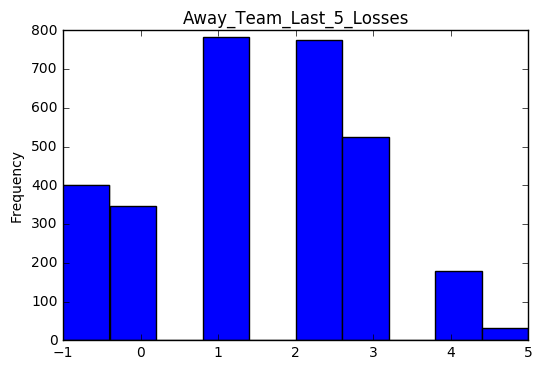

 1    782
 2    775
 3    525
-1    400
 0    347
 4    180
 5     31
Name: Away_Team_Last_5_Losses, dtype: int64


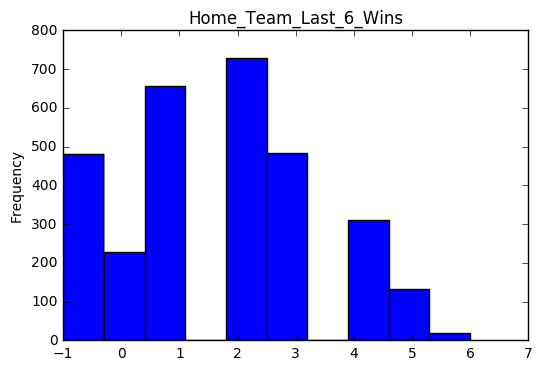

 2    729
 1    657
 3    483
-1    480
 4    312
 0    229
 5    132
 6     18
Name: Home_Team_Last_6_Wins, dtype: int64


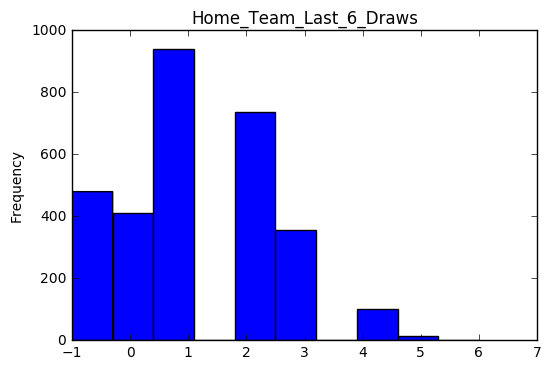

 1    940
 2    737
-1    480
 0    410
 3    356
 4    102
 5     13
 6      2
Name: Home_Team_Last_6_Draws, dtype: int64


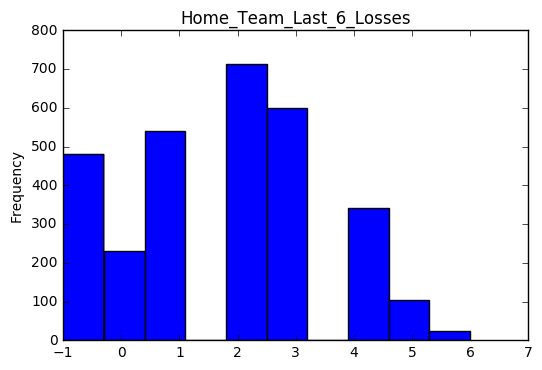

 2    714
 3    601
 1    541
-1    480
 4    343
 0    232
 5    105
 6     24
Name: Home_Team_Last_6_Losses, dtype: int64


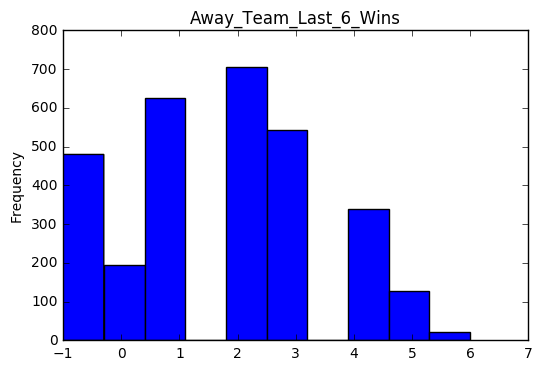

 2    706
 1    626
 3    544
-1    480
 4    339
 0    194
 5    128
 6     23
Name: Away_Team_Last_6_Wins, dtype: int64


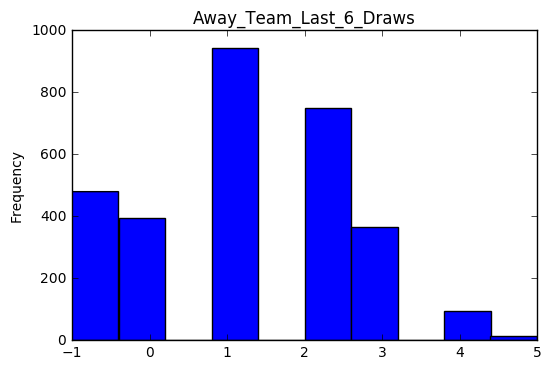

 1    942
 2    751
-1    480
 0    394
 3    365
 4     94
 5     14
Name: Away_Team_Last_6_Draws, dtype: int64


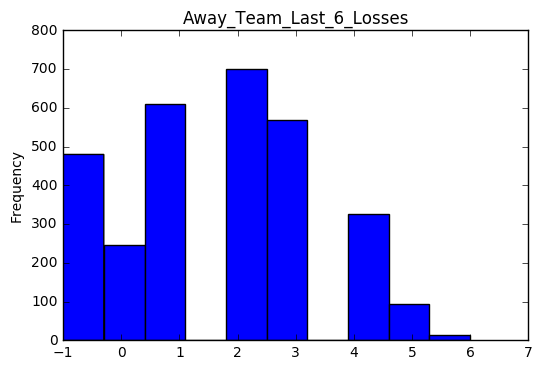

 2    701
 1    610
 3    569
-1    480
 4    326
 0    247
 5     94
 6     13
Name: Away_Team_Last_6_Losses, dtype: int64


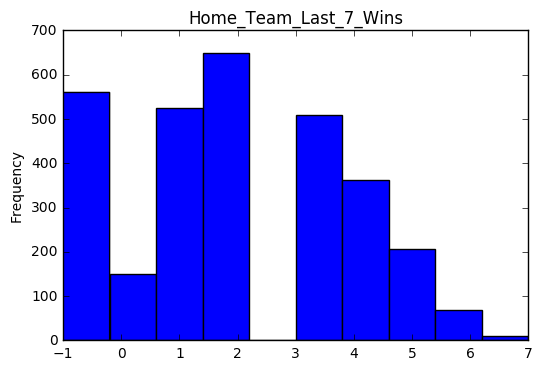

 2    650
-1    560
 1    525
 3    508
 4    362
 5    206
 0    150
 6     68
 7     11
Name: Home_Team_Last_7_Wins, dtype: int64


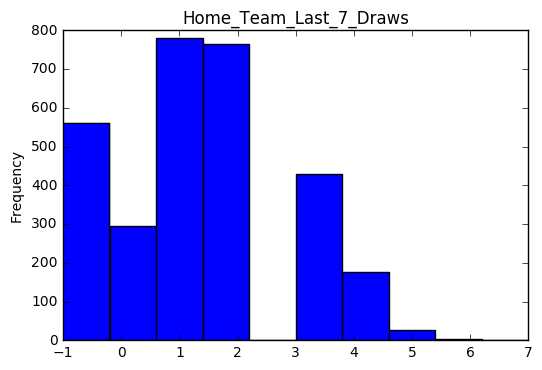

 1    780
 2    765
-1    560
 3    429
 0    296
 4    176
 5     28
 6      5
 7      1
Name: Home_Team_Last_7_Draws, dtype: int64


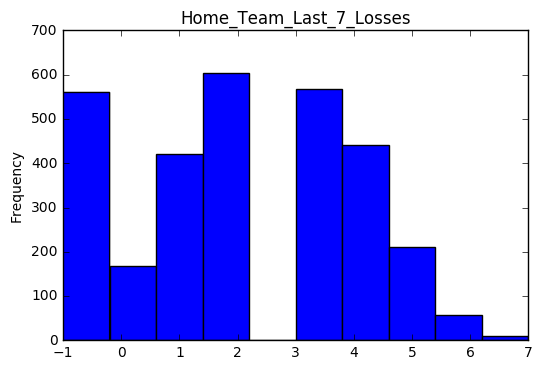

 2    603
 3    568
-1    560
 4    442
 1    420
 5    212
 0    168
 6     57
 7     10
Name: Home_Team_Last_7_Losses, dtype: int64


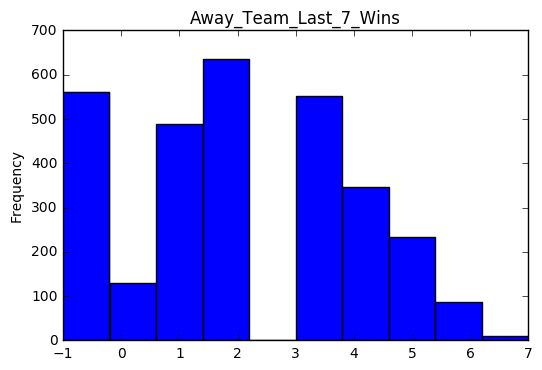

 2    635
-1    560
 3    551
 1    489
 4    346
 5    233
 0    129
 6     86
 7     11
Name: Away_Team_Last_7_Wins, dtype: int64


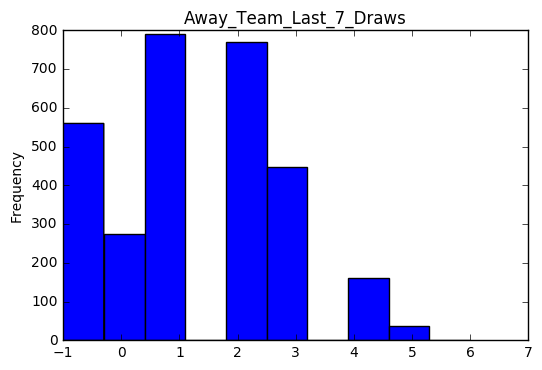

 1    790
 2    769
-1    560
 3    447
 0    274
 4    161
 5     37
 6      2
Name: Away_Team_Last_7_Draws, dtype: int64


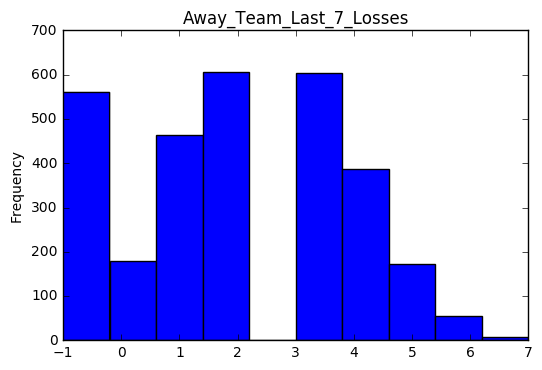

 2    607
 3    605
-1    560
 1    465
 4    388
 0    179
 5    173
 6     56
 7      7
Name: Away_Team_Last_7_Losses, dtype: int64


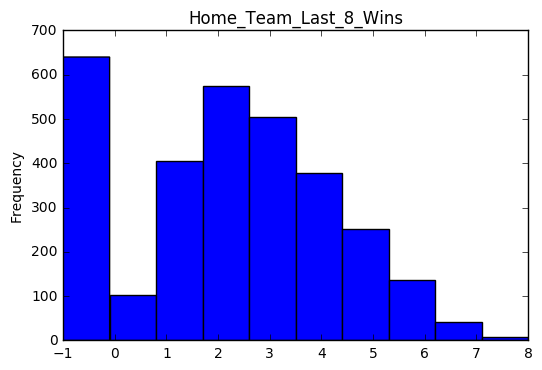

-1    640
 2    574
 3    504
 1    406
 4    378
 5    251
 6    137
 0    102
 7     41
 8      7
Name: Home_Team_Last_8_Wins, dtype: int64


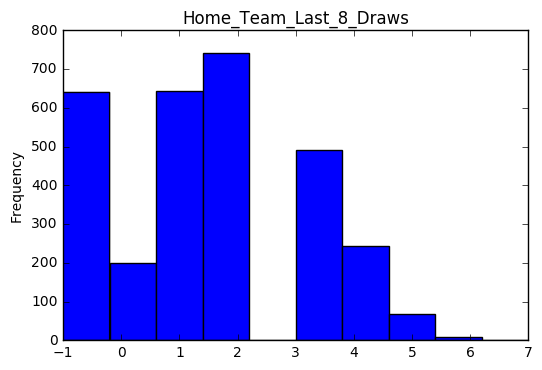

 2    741
 1    644
-1    640
 3    491
 4    245
 0    200
 5     69
 6      9
 7      1
Name: Home_Team_Last_8_Draws, dtype: int64


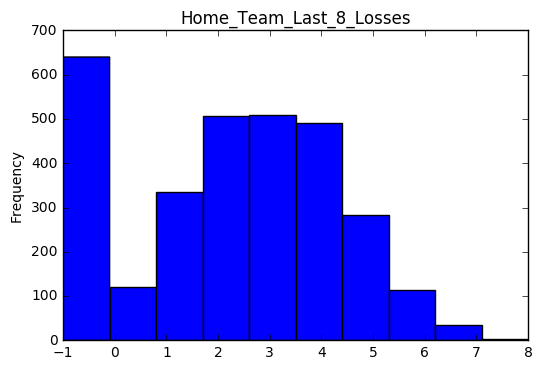

-1    640
 3    510
 2    507
 4    491
 1    335
 5    284
 0    121
 6    114
 7     34
 8      4
Name: Home_Team_Last_8_Losses, dtype: int64


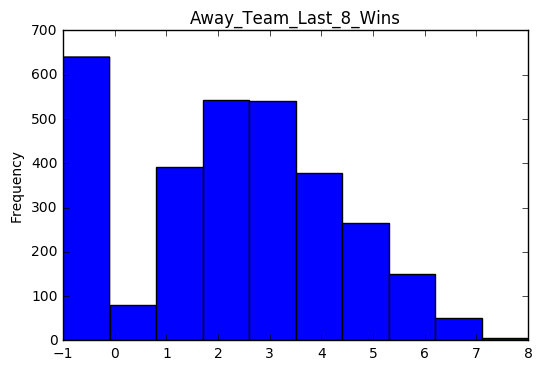

-1    640
 2    542
 3    540
 1    392
 4    378
 5    265
 6    149
 0     79
 7     50
 8      5
Name: Away_Team_Last_8_Wins, dtype: int64


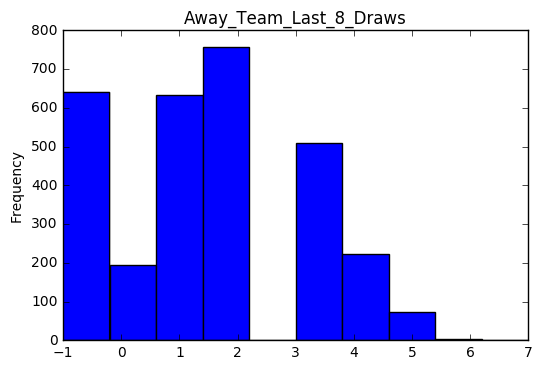

 2    758
-1    640
 1    633
 3    510
 4    223
 0    195
 5     74
 6      5
 7      2
Name: Away_Team_Last_8_Draws, dtype: int64


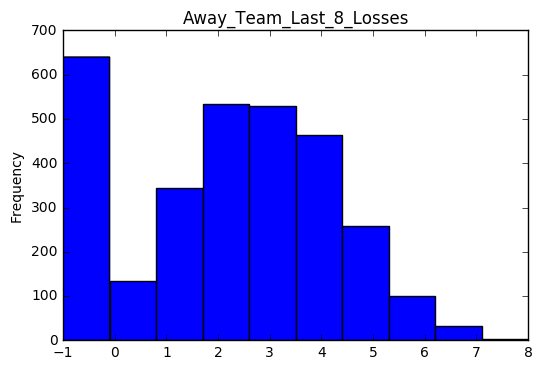

-1    640
 2    534
 3    530
 4    463
 1    344
 5    258
 0    135
 6    101
 7     32
 8      3
Name: Away_Team_Last_8_Losses, dtype: int64


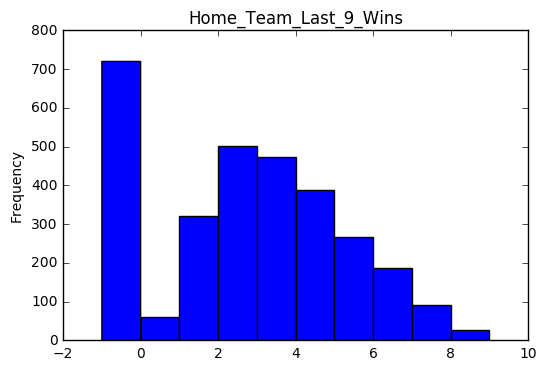

-1    720
 2    503
 3    473
 4    389
 1    321
 5    266
 6    188
 7     92
 0     60
 8     24
 9      4
Name: Home_Team_Last_9_Wins, dtype: int64


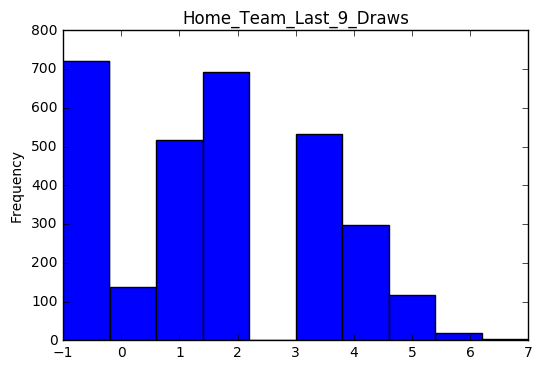

-1    720
 2    693
 3    534
 1    518
 4    297
 0    139
 5    116
 6     20
 7      3
Name: Home_Team_Last_9_Draws, dtype: int64


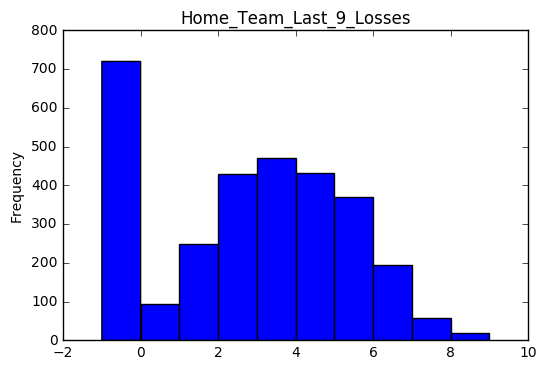

-1    720
 3    471
 4    433
 2    430
 5    371
 1    249
 6    194
 0     95
 7     58
 8     17
 9      2
Name: Home_Team_Last_9_Losses, dtype: int64


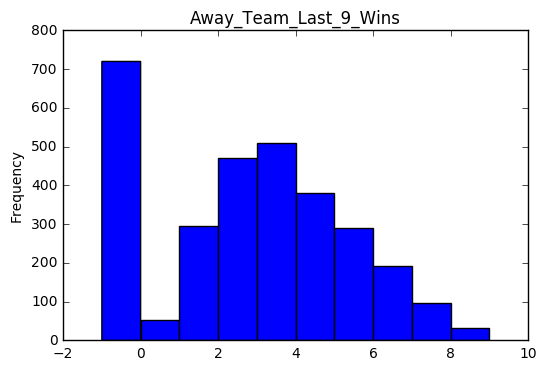

-1    720
 3    510
 2    472
 4    380
 1    295
 5    289
 6    192
 7     97
 0     54
 8     29
 9      2
Name: Away_Team_Last_9_Wins, dtype: int64


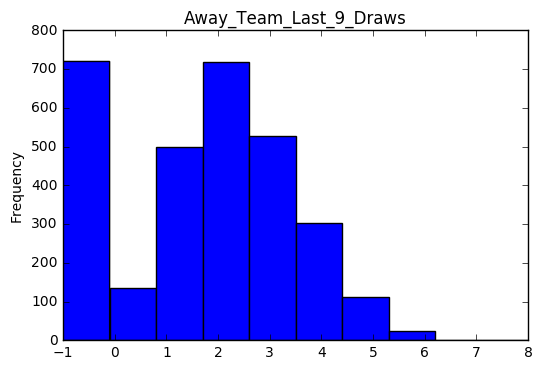

-1    720
 2    718
 3    528
 1    498
 4    302
 0    135
 5    112
 6     25
 7      1
 8      1
Name: Away_Team_Last_9_Draws, dtype: int64


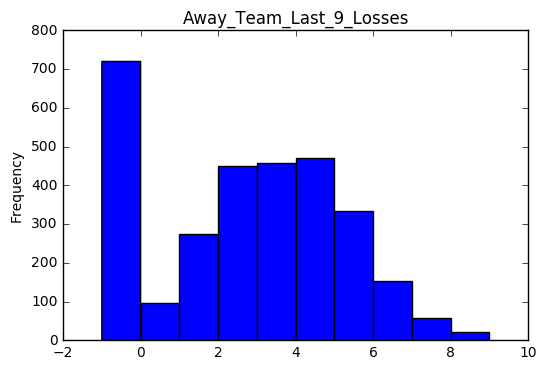

-1    720
 4    472
 3    458
 2    450
 5    334
 1    275
 6    154
 0     97
 7     58
 8     21
 9      1
Name: Away_Team_Last_9_Losses, dtype: int64


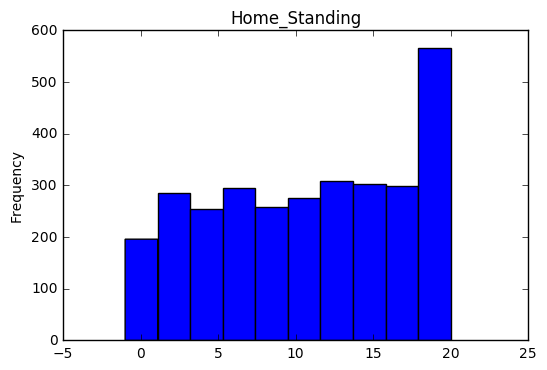

 20    219
 18    179
 19    168
 16    161
 15    156
 13    155
 7     154
 12    153
 3     149
 14    146
 10    143
 6     142
 17    137
 2     136
 9     134
 11    132
 5     129
 4     126
 8     125
 1     116
-1      80
Name: Home_Standing, dtype: int64


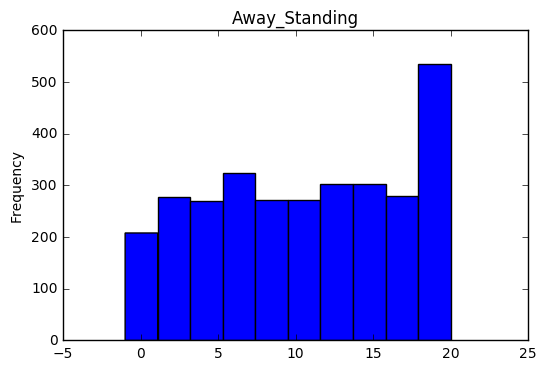

 20    220
 12    170
 6     165
 18    164
 7     160
 16    157
 15    154
 19    151
 14    148
 9     142
 2     139
 3     138
 10    138
 5     135
 4     134
 11    133
 13    133
 8     129
 1     128
 17    122
-1      80
Name: Away_Standing, dtype: int64


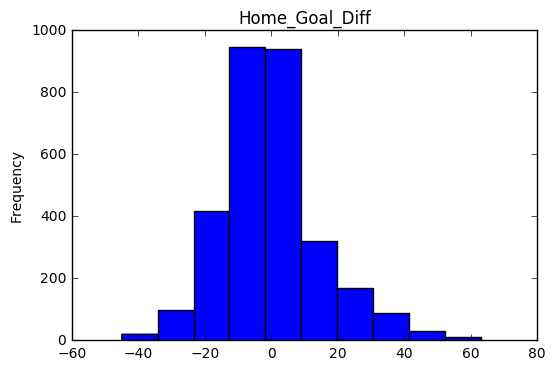

 0     211
-2     136
-1     130
 1     128
-3     124
-4     113
 2     102
-5      93
-6      92
 4      78
-10     70
 3      69
-7      69
-8      66
-15     65
-12     64
-9      62
 6      61
 7      58
-11     57
 5      57
-14     52
-16     49
-13     47
 8      46
 9      43
-18     37
-17     34
 12     33
-19     32
      ... 
 36      5
-32      5
 37      5
-41      4
-33      4
 40      4
 42      4
 50      4
 54      4
 63      3
-40      3
-42      3
 51      3
 49      3
 45      3
-36      3
-37      3
 46      2
 48      2
-45      2
-30      1
-39      1
 47      1
 53      1
-35      1
 58      1
 56      1
 52      1
 44      1
 60      1
Name: Home_Goal_Diff, dtype: int64


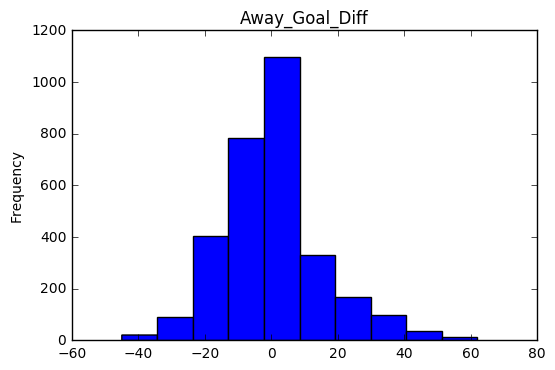

 0     205
 1     136
-2     134
-1     132
-3     120
-4     109
-5     103
 2      98
 3      92
-6      84
-10     75
 4      75
 5      72
-7      69
-14     66
-9      65
-11     63
 7      58
-15     53
 8      50
-8      48
-12     47
 6      46
-13     44
-18     42
 10     42
 9      41
-16     41
 12     37
-22     35
      ... 
-35      5
-41      5
 42      5
-32      5
-33      4
 40      4
-30      3
 47      3
-34      3
 53      3
 61      2
-36      2
 55      2
-40      2
-42      2
 51      2
 49      2
-39      2
 36      2
 59      1
-45      1
 62      1
 56      1
 58      1
 54      1
 46      1
 44      1
-44      1
-38      1
 60      1
Name: Away_Goal_Diff, dtype: int64


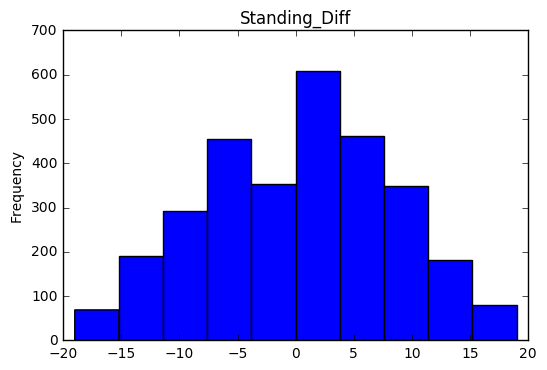

 0     250
 3     140
-2     137
-4     131
 2     127
 5     126
 6     125
-5     122
 4     120
 8     117
-3     111
-6     110
-1     105
 1      92
-7      91
 7      90
 10     84
 9      81
-8      80
-11     73
-10     71
-9      68
 11     66
-12     62
 12     57
-13     52
 13     51
-14     50
 14     43
 15     31
 16     30
-16     28
-15     27
 18     23
-17     22
 17     20
-18     13
 19      8
-19      6
Name: Standing_Diff, dtype: int64


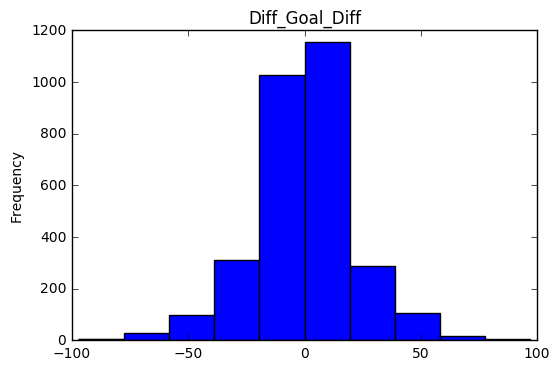

 0     181
-4      95
 3      92
-2      92
-3      91
 1      87
-1      80
 4      78
 2      75
-6      72
 6      71
-7      64
 7      63
-5      63
 5      62
-10     61
-11     53
 9      53
-9      53
 8      50
 10     46
-12     45
 12     44
-8      44
 13     42
 15     41
 14     39
 11     39
-13     36
-20     34
      ... 
-64      2
 60      2
-60      2
 56      2
-54      2
-78      2
 79      1
 85      1
-73      1
-56      1
-84      1
-71      1
-69      1
-61      1
 73      1
-75      1
 75      1
-97      1
 86      1
 71      1
 58      1
-74      1
 72      1
-72      1
 70      1
-70      1
 68      1
-66      1
 62      1
 97      1
Name: Diff_Goal_Diff, dtype: int64


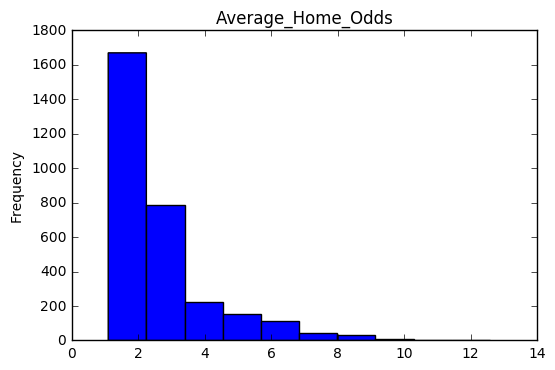

1.30    37
2.22    33
1.21    26
1.20    25
2.36    24
2.12    24
2.18    24
2.17    23
1.22    23
2.02    23
1.81    23
1.45    22
1.88    22
1.42    21
1.98    21
2.03    21
2.07    21
1.76    21
2.10    21
1.96    21
1.43    21
2.47    21
2.48    20
2.19    20
1.38    20
2.08    19
1.24    19
1.36    19
1.28    19
1.35    19
        ..
7.38     1
4.83     1
6.10     1
4.41     1
7.59     1
5.15     1
5.32     1
6.92     1
6.99     1
8.27     1
6.24     1
3.36     1
3.58     1
6.68     1
3.89     1
4.51     1
5.39     1
8.18     1
5.53     1
6.89     1
3.40     1
6.39     1
3.29     1
3.96     1
5.44     1
5.94     1
5.72     1
7.56     1
7.97     1
9.75     1
Name: Average_Home_Odds, dtype: int64


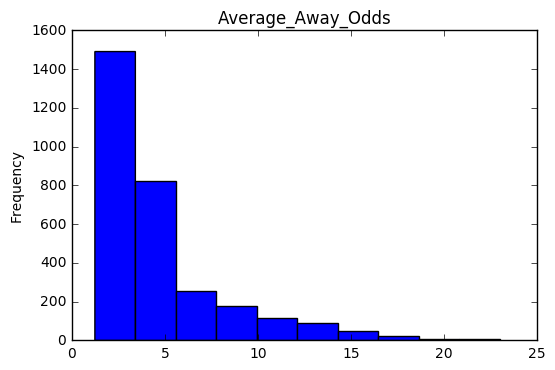

3.32     18
3.42     17
1.86     16
1.70     16
1.59     16
1.61     16
2.84     16
2.94     16
3.45     15
2.28     15
3.43     15
3.22     14
2.78     14
3.12     14
3.82     14
2.76     14
2.92     13
3.62     13
3.78     13
3.67     13
1.54     13
2.72     12
2.85     12
3.35     12
1.72     12
1.52     12
3.53     12
3.96     12
3.33     12
2.36     12
         ..
22.67     1
4.61      1
19.08     1
4.09      1
5.27      1
10.96     1
4.91      1
8.36      1
13.58     1
15.58     1
7.03      1
6.87      1
5.56      1
5.53      1
9.72      1
6.36      1
11.38     1
10.30     1
6.99      1
7.19      1
4.22      1
6.68      1
10.04     1
8.93      1
5.83      1
7.01      1
6.31      1
6.82      1
7.76      1
7.51      1
Name: Average_Away_Odds, dtype: int64


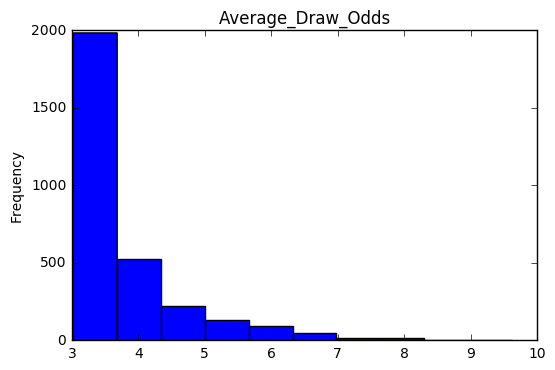

3.22    128
3.28    117
3.32     89
3.24     80
3.23     77
3.38     69
3.42     65
3.25     61
3.33     61
3.30     60
3.21     59
3.27     56
3.29     56
3.26     55
3.37     49
3.35     48
3.20     47
3.43     40
3.52     40
3.31     39
3.48     38
3.40     37
3.19     37
3.47     36
3.34     31
3.45     28
3.58     28
3.53     26
3.39     24
3.64     24
       ... 
4.96      1
3.03      1
5.55      1
7.03      1
9.62      1
3.02      1
5.94      1
5.80      1
4.95      1
6.79      1
4.78      1
3.09      1
5.10      1
6.62      1
5.32      1
8.04      1
6.55      1
5.37      1
8.17      1
6.80      1
5.26      1
6.84      1
6.91      1
4.63      1
3.14      1
6.54      1
4.51      1
6.26      1
5.23      1
5.66      1
Name: Average_Draw_Odds, dtype: int64


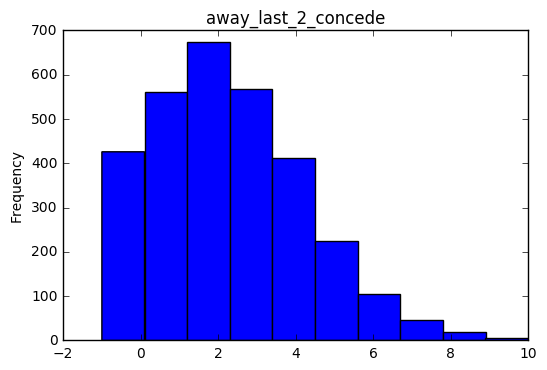

 2     673
 3     567
 1     562
 4     411
 0     266
 5     225
-1     160
 6     106
 7      46
 8      18
 9       3
 10      3
Name: away_last_2_concede, dtype: int64


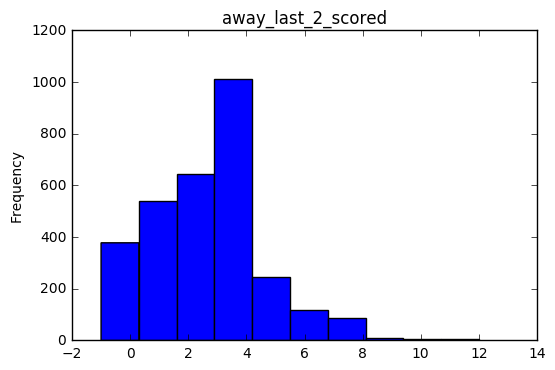

 2     644
 3     602
 1     538
 4     410
 5     245
 0     218
-1     160
 6     117
 7      59
 8      26
 9      11
 10      6
 11      3
 12      1
Name: away_last_2_scored, dtype: int64


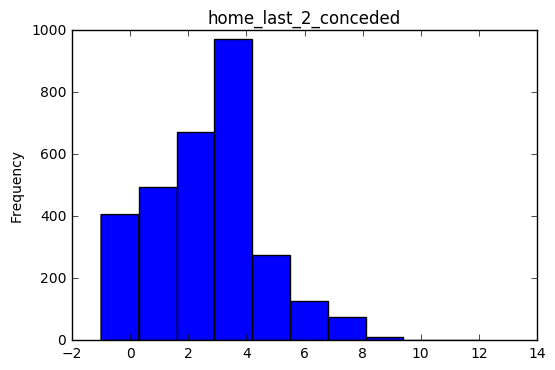

 2     673
 3     562
 1     494
 4     409
 5     276
 0     246
-1     160
 6     128
 7      56
 8      20
 9      12
 10      2
 11      1
 12      1
Name: home_last_2_conceded, dtype: int64


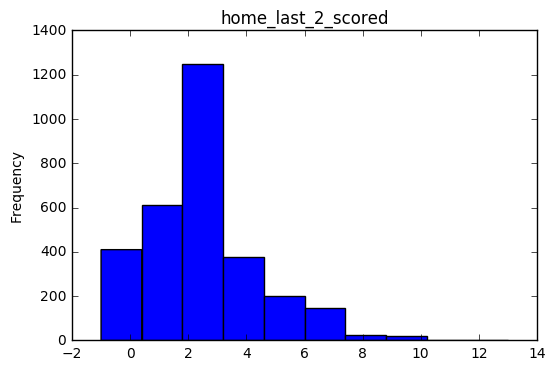

 2     665
 1     611
 3     585
 4     377
 0     250
 5     202
-1     160
 6     100
 7      45
 8      24
 9      11
 10      7
 13      1
 11      1
 12      1
Name: home_last_2_scored, dtype: int64


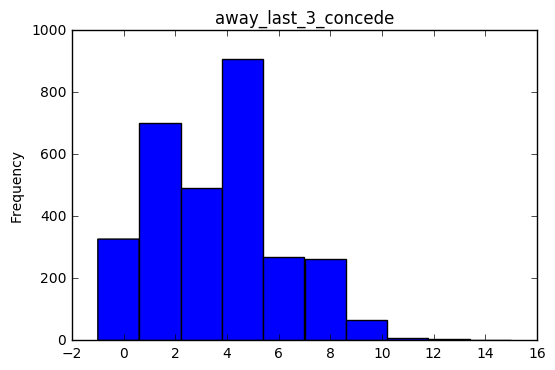

 4     495
 3     491
 2     445
 5     412
 6     268
 1     258
-1     240
 7     167
 8      96
 0      87
 9      43
 10     23
 11      9
 12      3
 13      2
 15      1
Name: away_last_3_concede, dtype: int64


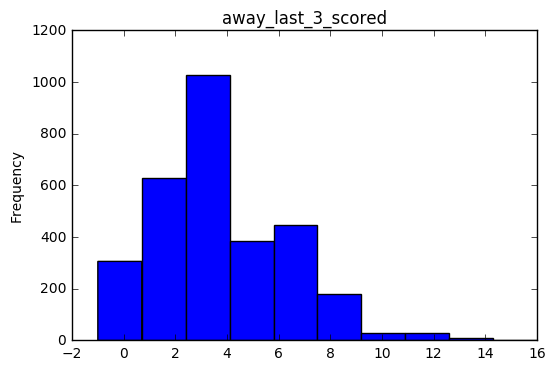

 3     528
 4     500
 2     412
 5     386
 6     270
-1     240
 1     216
 7     175
 8     119
 0      66
 9      61
 10     28
 11     16
 12     12
 13      7
 14      3
 16      1
Name: away_last_3_scored, dtype: int64


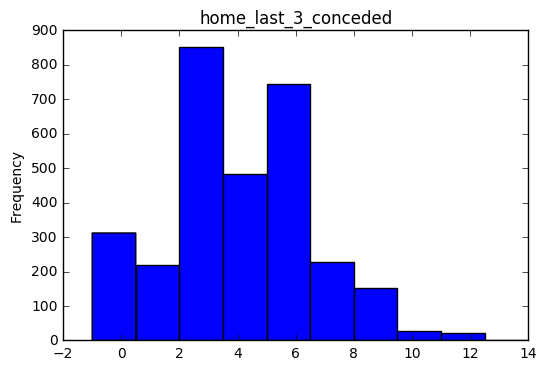

 4     482
 5     464
 3     429
 2     424
 6     280
-1     240
 7     228
 1     220
 8      97
 0      72
 9      54
 10     26
 11     17
 12      5
 13      1
 14      1
Name: home_last_3_conceded, dtype: int64


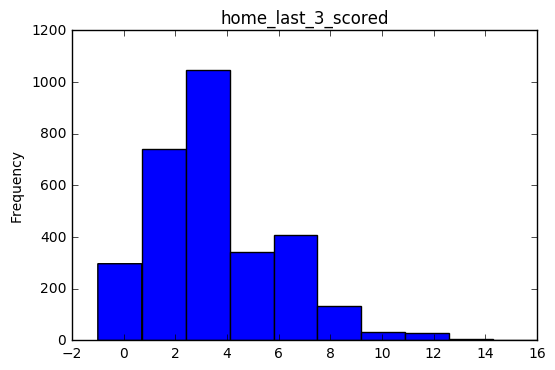

 3     554
 4     493
 2     468
 5     342
 1     275
 6     254
-1     240
 7     156
 8      87
 0      57
 9      46
 10     34
 11     17
 12     10
 13      3
 14      3
 16      1
Name: home_last_3_scored, dtype: int64


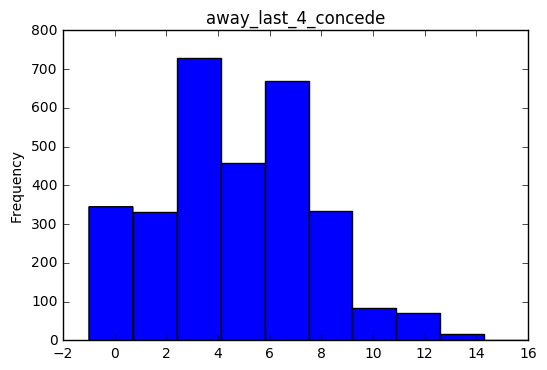

 5     457
 4     373
 6     369
 3     357
-1     320
 7     300
 2     231
 8     195
 9     138
 1     100
 10     84
 11     43
 12     29
 0      25
 13     11
 14      6
 15      1
 16      1
Name: away_last_4_concede, dtype: int64


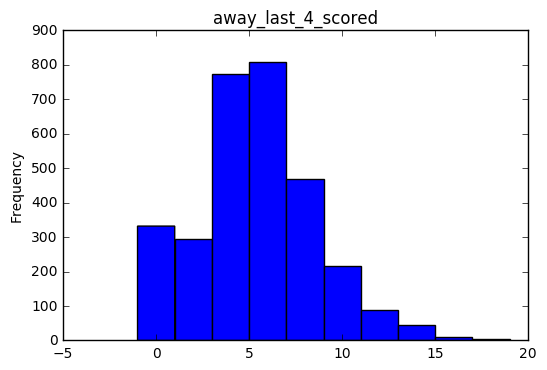

 5     447
 4     442
 6     361
 3     331
-1     320
 7     281
 2     206
 8     187
 9     130
 1      89
 10     85
 11     53
 12     34
 13     32
 14     14
 0      12
 15      9
 17      3
 16      2
 18      1
 19      1
Name: away_last_4_scored, dtype: int64


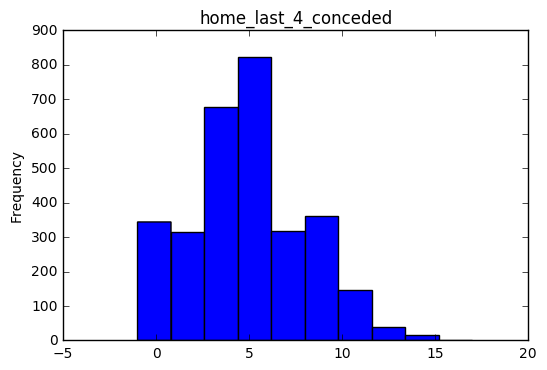

 5     425
 6     397
 4     373
-1     320
 7     319
 3     306
 8     219
 2     211
 9     141
 1     103
 10     92
 11     54
 0      24
 12     24
 13     16
 14     11
 15      4
 17      1
Name: home_last_4_conceded, dtype: int64


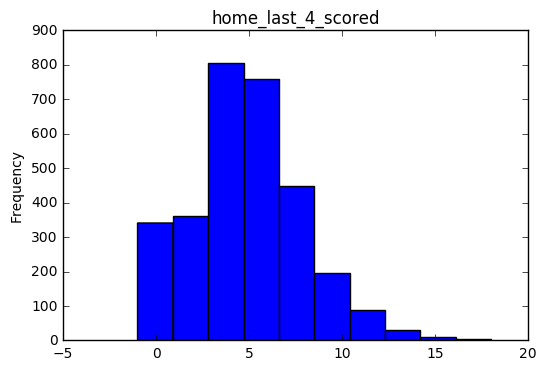

 4     442
 5     417
 3     363
 6     341
-1     320
 2     261
 7     251
 8     197
 9     128
 1     100
 10     67
 11     63
 12     26
 0      21
 13     18
 14     13
 16      5
 15      4
 17      2
 18      1
Name: home_last_4_scored, dtype: int64


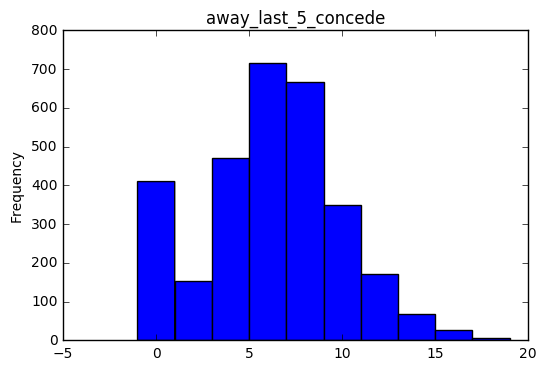

-1     400
 5     360
 6     355
 7     351
 8     316
 4     269
 3     203
 9     198
 10    152
 2     113
 11    108
 12     64
 13     43
 1      40
 14     24
 15     22
 0      10
 16      5
 17      4
 18      2
 19      1
Name: away_last_5_concede, dtype: int64


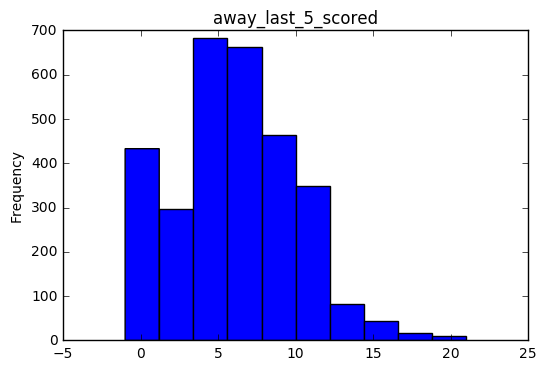

-1     400
 5     384
 6     359
 7     304
 4     300
 8     258
 9     206
 3     192
 10    169
 11    108
 2     104
 12     71
 13     46
 14     36
 15     32
 1      28
 16     12
 18      9
 17      8
 19      6
 0       5
 21      2
 20      1
Name: away_last_5_scored, dtype: int64


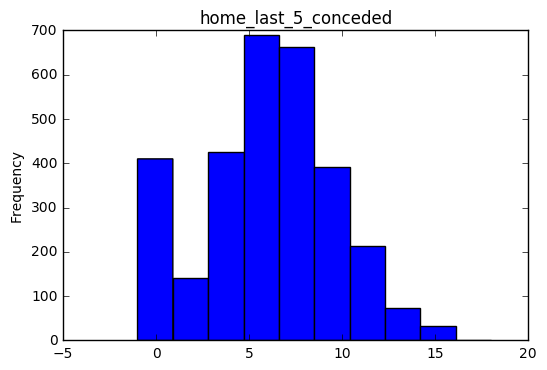

-1     400
 6     364
 7     341
 5     326
 8     321
 4     231
 9     227
 3     194
 10    164
 11    140
 2     101
 12     74
 13     42
 1      40
 14     31
 15     22
 16     11
 0      10
 18      1
Name: home_last_5_conceded, dtype: int64


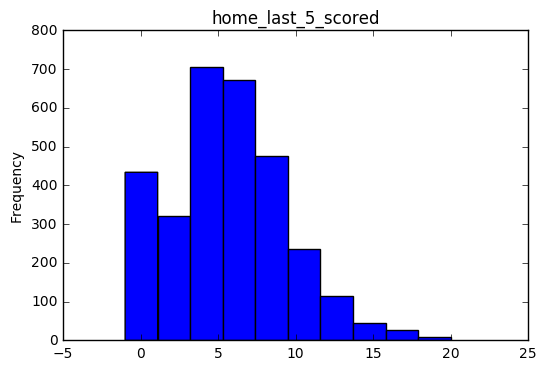

-1     400
 5     374
 6     343
 4     332
 7     329
 8     283
 3     211
 9     194
 10    134
 2     110
 11    101
 12     66
 13     49
 1      30
 14     26
 15     20
 16     14
 17     12
 18      4
 0       4
 19      2
 20      2
Name: home_last_5_scored, dtype: int64


In [50]:
#Let's do some investigation on the new features

cols = matches.columns[31:]

for col in cols:
    matches[col].plot(kind='hist')
    plt.title(col)
    plt.show()
    print matches[col].value_counts()

This concludes the 'last-k-goals' features!

##### Day of the week

The goal of this feature is to append a categorical feature 'Day of the Week' to each match. Because some matches happen during the middle of the week, maybe that could provide some information to the model.

In [54]:
dates_raw = matches['date'].tolist()
dates_split = []
for date in dates_raw:
    dates_split.append(date.split(' ')[0])

dates_split[0]

'8/17/08'

In [55]:
day_of_week = map(lambda x: time.strptime(x,'%m/%d/%y').tm_wday ,dates_split)

matches['day_of_week'] = day_of_week

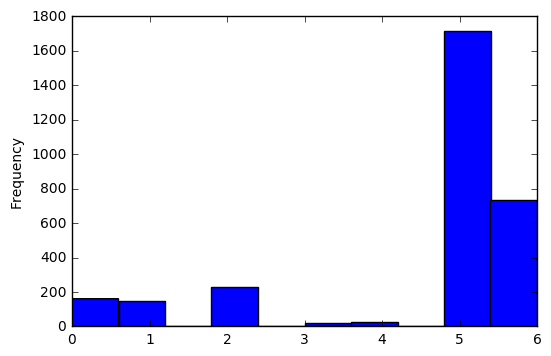

In [56]:
matches['day_of_week'].plot(kind='hist')   #Most matches played on saturday (day of week =5), but matches are also played on other days

In [57]:
matches['day_of_week'].value_counts()   #Most matches played on saturday (day of week =5), but matches are also played on other days

5    1718
6     736
2     230
0     161
1     150
4      23
3      22
Name: day_of_week, dtype: int64

In [58]:
# Let's re-investigate our matches dataframe

matches.tail()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Result_Target,...,home_last_3_scored,away_last_4_concede,away_last_4_scored,home_last_4_conceded,home_last_4_scored,away_last_5_concede,away_last_5_scored,home_last_5_conceded,home_last_5_scored,day_of_week
3035,4764,2015/2016,9,10/17/15 0:00,1988795,8466,8197,2,2,0.0,...,8,10,9,5,8,11,10,5,11,5
3036,4765,2015/2016,9,10/19/15 0:00,1988796,10003,10194,0,1,0.0,...,3,5,5,6,3,6,5,7,5,0
3037,4766,2015/2016,9,10/17/15 0:00,1988797,8586,8650,0,0,0.0,...,7,7,6,3,8,10,6,3,8,5
3038,4767,2015/2016,9,10/17/15 0:00,1988798,9817,9825,0,3,0.0,...,3,4,10,3,4,4,11,5,4,5
3039,4768,2015/2016,9,10/17/15 0:00,1988799,8659,8472,1,0,1.0,...,3,8,2,5,3,10,4,5,4,5


In [59]:
day_of_week_dummies = pd.get_dummies(matches['day_of_week'])
day_of_week_dummies.columns = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

#Add new binary columns to matches dataframe

matches['Monday'] = day_of_week_dummies.Monday
matches['Tuesday'] = day_of_week_dummies.Tuesday
matches['Wednesday'] = day_of_week_dummies.Wednesday
matches['Thursday'] = day_of_week_dummies.Thursday
matches['Friday'] = day_of_week_dummies.Friday
matches['Saturday'] = day_of_week_dummies.Saturday
matches['Sunday'] = day_of_week_dummies.Sunday

del matches['day_of_week']


In [60]:
matches.head()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Result_Target,...,away_last_5_scored,home_last_5_conceded,home_last_5_scored,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,1729,2008/2009,1,8/17/08 0:00,489042,10260,10261,1,1,0.0,...,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1730,2008/2009,1,8/16/08 0:00,489043,9825,8659,1,0,1.0,...,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1731,2008/2009,1,8/16/08 0:00,489044,8472,8650,0,1,0.0,...,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1732,2008/2009,1,8/16/08 0:00,489045,8654,8528,2,1,1.0,...,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1733,2008/2009,1,8/17/08 0:00,489046,10252,8456,4,2,1.0,...,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Now let's add some information about each team

In [61]:
teams = pd.read_csv('/Users/mtetkosk/Google Drive/Data Science Projects/data/processed/EPL_teams.csv')
print teams.shape
teams.head()

(34, 6)


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,ID
0,3457,10260,11,Manchester United,MUN,10260
1,3458,10261,13,Newcastle United,NEW,10261
2,3459,9825,1,Arsenal,ARS,9825
3,3460,8659,109,West Bromwich Albion,WBA,8659
4,3461,8472,106,Sunderland,SUN,8472


In [62]:
#Let's reduce the dataframe only to the columns we need
keepcols = ['team_api_id','team_long_name']

for col in teams.columns:
    if col not in keepcols:
        del teams[col]

teams.head()

,team_api_id,team_long_name
0,10260,Manchester United
1,10261,Newcastle United
2,9825,Arsenal
3,8659,West Bromwich Albion
4,8472,Sunderland


In [63]:
matches = matches.merge(teams,how = 'left', left_on = 'home_team_api_id', right_on = 'team_api_id' )
matches = matches.merge(teams,how = 'left', left_on = 'away_team_api_id', right_on = 'team_api_id')

matches.head()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Result_Target,...,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,team_api_id_x,team_long_name_x,team_api_id_y,team_long_name_y
0,1729,2008/2009,1,8/17/08 0:00,489042,10260,10261,1,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,10260,Manchester United,10261,Newcastle United
1,1730,2008/2009,1,8/16/08 0:00,489043,9825,8659,1,0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,9825,Arsenal,8659,West Bromwich Albion
2,1731,2008/2009,1,8/16/08 0:00,489044,8472,8650,0,1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,8472,Sunderland,8650,Liverpool
3,1732,2008/2009,1,8/16/08 0:00,489045,8654,8528,2,1,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,8654,West Ham United,8528,Wigan Athletic
4,1733,2008/2009,1,8/17/08 0:00,489046,10252,8456,4,2,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,10252,Aston Villa,8456,Manchester City


In [64]:
remove_cols = ['team_api_id_x','team_api_id_y']

for col in matches.columns:
    if col in remove_cols:
        del matches[col]
        
matches.rename(columns={'team_long_name_x': 'Home_Team', 'team_long_name_y': 'Away_Team'}, inplace=True)

In [65]:
matches.season.value_counts()

2009/2010    380
2013/2014    380
2010/2011    380
2011/2012    380
2012/2013    380
2014/2015    380
2008/2009    380
2015/2016    380
Name: season, dtype: int64

In [66]:
print matches.head()
print matches.shape  # We now have 56 total columns (some of them we will get rid of..)

     id     season  stage          date  match_api_id  home_team_api_id  \
0  1729  2008/2009      1  8/17/08 0:00        489042             10260   
1  1730  2008/2009      1  8/16/08 0:00        489043              9825   
2  1731  2008/2009      1  8/16/08 0:00        489044              8472   
3  1732  2008/2009      1  8/16/08 0:00        489045              8654   
4  1733  2008/2009      1  8/17/08 0:00        489046             10252   

   away_team_api_id  home_team_goal  away_team_goal  Result_Target  \
0             10261               1               1            0.0   
1              8659               1               0            1.0   
2              8650               0               1            0.0   
3              8528               2               1            1.0   
4              8456               4               2            1.0   

           ...           home_last_5_scored  Monday  Tuesday  Wednesday  \
0          ...                           -1     0.0  

### Load Team Attributes

In [67]:
team_attributes = pd.read_csv('/Users/mtetkosk/Google Drive/Data Science Projects/data/processed/EPL_team_attributes.csv')
team_attributes.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,ID
0,71,1,9825,2/22/10 0:00,66,Balanced,NaN,Little,30,Short,...,Normal,Free Form,30,Deep,40,Press,50,Normal,Cover,9825
1,72,1,9825,2/22/11 0:00,75,Fast,NaN,Little,40,Mixed,...,Normal,Free Form,50,Medium,40,Press,45,Normal,Cover,9825
2,73,1,9825,2/22/12 0:00,25,Slow,NaN,Little,32,Short,...,Little,Free Form,57,Medium,57,Press,52,Normal,Cover,9825
3,74,1,9825,9/20/13 0:00,30,Slow,NaN,Little,29,Short,...,Normal,Free Form,64,Medium,54,Press,52,Normal,Cover,9825
4,75,1,9825,9/19/14 0:00,59,Balanced,51.0,Normal,26,Short,...,Normal,Free Form,51,Medium,44,Press,52,Normal,Cover,9825


In [68]:
# Let's see what columns make up this dataframe
team_attributes.columns

Index([u'id', u'team_fifa_api_id', u'team_api_id', u'date',
       u'buildUpPlaySpeed', u'buildUpPlaySpeedClass', u'buildUpPlayDribbling',
       u'buildUpPlayDribblingClass', u'buildUpPlayPassing',
       u'buildUpPlayPassingClass', u'buildUpPlayPositioningClass',
       u'chanceCreationPassing', u'chanceCreationPassingClass',
       u'chanceCreationCrossing', u'chanceCreationCrossingClass',
       u'chanceCreationShooting', u'chanceCreationShootingClass',
       u'chanceCreationPositioningClass', u'defencePressure',
       u'defencePressureClass', u'defenceAggression',
       u'defenceAggressionClass', u'defenceTeamWidth',
       u'defenceTeamWidthClass', u'defenceDefenderLineClass', u'ID'],
      dtype='object')

In [69]:
# Remove columns that we won't use
remove_cols = ['buildUpPlaySpeedClass','buildUpPlayDribbling','buildUpPlayPassingClass','chanceCreationPassingClass',\
               'chanceCreationCrossingClass','chanceCreationShootingClass','defencePressureClass','defenceAggressionClass',\
               'defenceTeamWidthClass','ID']

for col in team_attributes.columns:
    if col in remove_cols:
        del team_attributes[col]
        
team_attributes.shape ## Now we have just 16 columns

(204, 16)

In [70]:
# Split dates to get just the date component
dates_raw = team_attributes['date'].tolist()
dates_split = []
for date in dates_raw:
    dates_split.append(date.split(' ')[0])

In [71]:
# Extract the year and month from each record and append to team_attributes dataframe
team_attributes['month'] = map(lambda x: time.strptime(x,'%m/%d/%y').tm_mon ,dates_split)
team_attributes['year'] = map(lambda x: time.strptime(x,'%m/%d/%y').tm_year ,dates_split)

In [72]:
def DetermineSeason(df):
    if df['year'] == 2008:
        return '2008/2009'
    if df['year'] == 2009:
        if df['month'] < 8:
            return '2008/2009'
        else:
            return '2009/2010'
    if df['year'] == 2010:
        if df['month'] < 8:
            return '2009/2010'
        else:
            return '2010/2011'
    if df['year'] == 2011:
        if df['month'] < 8:
            return '2010/2011'
        else:
            return '2011/2012'
    if df['year'] == 2012:
        if df['month'] < 8:
            return '2011/2012'
        else:
            return '2012/2013'
    if df['year'] == 2013:
        if df['month'] < 8:
            return '2012/2013'
        else:
            return '2013/2014'
    if df['year'] == 2014:
        if df['month'] < 8:
            return '2013/2014'
        else:
            return '2014/2015'
    if df['year'] == 2015:
        if df['month'] < 8:
            return '2014/2015'
        else:
            return '2015/2016'
    if df['year'] == 2016:
        if df['month'] < 8:
            return '2015/2016'
        else:
            return '2016/2017'

In [73]:
team_attributes['season'] = team_attributes.apply(DetermineSeason, axis = 1)

In [74]:
team_attributes.head(20)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass,month,year,season
0,71,1,9825,2/22/10 0:00,66,Little,30,Free Form,30,45,35,Free Form,30,40,50,Cover,2,2010,2009/2010
1,72,1,9825,2/22/11 0:00,75,Little,40,Free Form,40,45,65,Free Form,50,40,45,Cover,2,2011,2010/2011
2,73,1,9825,2/22/12 0:00,25,Little,32,Organised,41,34,30,Free Form,57,57,52,Cover,2,2012,2011/2012
3,74,1,9825,9/20/13 0:00,30,Little,29,Organised,41,55,39,Free Form,64,54,52,Cover,9,2013,2013/2014
4,75,1,9825,9/19/14 0:00,59,Normal,26,Organised,28,55,64,Free Form,51,44,52,Cover,9,2014,2014/2015
5,76,1,9825,9/10/15 0:00,59,Normal,30,Organised,28,44,46,Free Form,51,44,52,Cover,9,2015,2015/2016
6,77,2,10252,2/22/10 0:00,70,Little,59,Organised,65,70,50,Free Form,30,70,30,Cover,2,2010,2009/2010
7,78,2,10252,2/22/11 0:00,65,Little,50,Organised,45,55,50,Organised,35,45,65,Cover,2,2011,2010/2011
8,79,2,10252,2/22/12 0:00,67,Little,58,Organised,44,60,56,Organised,43,50,52,Cover,2,2012,2011/2012
9,80,2,10252,9/20/13 0:00,63,Little,59,Organised,52,55,34,Organised,39,41,54,Cover,9,2013,2013/2014


In [75]:
team_attributes['season'].unique()   # By using team attributes, it eliminates data from 2008/2009 and 2012/2013 season! shoot..

array(['2009/2010', '2010/2011', '2011/2012', '2013/2014', '2014/2015',
       '2015/2016'], dtype=object)

In [76]:
team_attributes['season'].value_counts()

2014/2015    34
2009/2010    34
2010/2011    34
2015/2016    34
2013/2014    34
2011/2012    34
Name: season, dtype: int64

In [77]:
## Let's test merging the team features with the matches dataframe

matches = matches.merge(team_attributes, how = 'inner', left_on = ['home_team_api_id','season'], right_on = \
                  ['team_api_id','season'])

matches.head()

,id_x,season,stage,date_x,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Result_Target,...,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass,month,year
0,2109,2009/2010,1,8/16/09 0:00,658571,10260,8658,1,0,1.0,...,45,70,65,Free Form,40,50,40,Cover,2,2010
1,2130,2009/2010,11,10/31/09 0:00,658710,10260,8655,2,0,1.0,...,45,70,65,Free Form,40,50,40,Cover,2,2010
2,2156,2009/2010,13,11/21/09 0:00,658796,10260,8668,3,0,1.0,...,45,70,65,Free Form,40,50,40,Cover,2,2010
3,2179,2009/2010,16,12/12/09 0:00,658819,10260,10252,0,1,0.0,...,45,70,65,Free Form,40,50,40,Cover,2,2010
4,2192,2009/2010,17,12/15/09 0:00,658832,10260,8602,3,0,1.0,...,45,70,65,Free Form,40,50,40,Cover,2,2010


In [78]:
matches = matches.merge(team_attributes, how = 'inner', left_on = ['away_team_api_id','season'], right_on = \
                  ['team_api_id','season'])

In [79]:
matches.shape  # We have reduced the rows from 3040 to 2280...lost 25% of the data!.. We lose 2008/2009 and 2012/2013

(2280, 134)

In [80]:
matches.season.value_counts()

2009/2010    380
2013/2014    380
2010/2011    380
2011/2012    380
2014/2015    380
2015/2016    380
Name: season, dtype: int64

### Stage to categorical

In [81]:
def Stage2Cat(df):
    if df['stage'] < 22:
        return 'Before Transfer Window'
    else:
        return 'After Transfer Window'

In [82]:
matches['Stage_Cat'] = matches.apply(Stage2Cat, axis = 1)

In [83]:
stage_cat_dummies = pd.get_dummies(matches['Stage_Cat'])
#del matches['Stage_Cat']
matches = pd.concat([matches,stage_cat_dummies], axis = 1)

#### Promoted Teams Flag

The goal of this feature is to have a flag that indicates if a team was newly promoted that season

In [84]:
promoted_teams = {'2009/2010': ['Wolverhampton Wanderers','Birmingham City','Burnley'],\
                  '2010/2011': ['Newcastle United','West Bromwich Albion','Blackpool'],\
                  '2011/2012': ['Queens Park Rangers','Norwich City','Swansea City'],\
                  '2012/2013': ['Reading','Southampton','West Ham United'],\
                  '2013/2014': ['Cardiff City','Hull City','Crystal Palace'],\
                  '2014/2015': ['Leicester City','Burnley','Queens Park Rangers'],\
                  '2015/2016': ['AFC Bournemouth','Watford','Norwich City']}

In [85]:
def HomePromotedTeam(df):
    seasonlist = matches['season'].unique().tolist()
    for season in seasonlist:
        if df['Home_Team'] in promoted_teams[season]:
            return 1
        else:
            return 0
def AwayPromotedTeam(df):
    seasonlist = matches['season'].unique().tolist()
    for season in seasonlist:
        if df['Away_Team'] in promoted_teams[season]:
            return 1
        else:
            return 0

In [86]:
matches['Home_Promoted_Flag'] = matches.apply(HomePromotedTeam, axis=1)
matches['Away_Promoted_Flat'] = matches.apply(AwayPromotedTeam, axis = 1)

In [87]:
matches.shape

(2280, 139)

### Major Teams Flag

In [91]:
major_teams = ['Manchester United','Arsenal','Chelsea','Manchester City','Liverpool']

In [97]:
def HomeMajorTeams(df):
    if df['Home_Team'] in major_teams:
        return 1
    else:
        return 0
    
def AwayMajorTeams(df):
    if df['Away_Team'] in major_teams:
        return 1
    else:
        return 0

In [98]:
matches['Home_Major_Team'] = matches.apply(HomeMajorTeams,axis=1)
matches['Away_Major_Team'] = matches.apply(AwayMajorTeams,axis=1)

### Now we need to convert features to numeric or dummies to use in the modeling process

In [100]:
for col in matches.columns:
    if matches[col].dtype == 'object':
        print col

season
date_x
Home_Team
Away_Team
date_y
buildUpPlayDribblingClass_x
buildUpPlayPositioningClass_x
chanceCreationPositioningClass_x
defenceDefenderLineClass_x
date
buildUpPlayDribblingClass_y
buildUpPlayPositioningClass_y
chanceCreationPositioningClass_y
defenceDefenderLineClass_y
Stage_Cat


In [101]:
def CreateDummies(df,col):
    dummies = pd.get_dummies(df[col])
    del df[col]
    if col == 'Home_Team':
        dummies.columns = dummies.columns +'_home_team'
    elif col == 'Away_Team':
        dummies.columns = dummies.columns +'_away_team'
    else:
        dummies.columns = dummies.columns + '_'+col
    df = pd.concat([df,dummies], axis=1)
    return df

In [102]:
dummy_cols = ['season','Home_Team','Away_Team','buildUpPlayDribblingClass_x',\
              'buildUpPlayPositioningClass_x', 'chanceCreationPositioningClass_x',\
              'defenceDefenderLineClass_x','buildUpPlayDribblingClass_y','buildUpPlayPositioningClass_y',\
              'chanceCreationPositioningClass_y','defenceDefenderLineClass_y']

In [103]:
for dcol in dummy_cols:
    matches = CreateDummies(matches,dcol)

matches.shape

(2280, 214)

In [104]:
for col in matches.columns:
    if matches[col].dtype == 'object':
        print col

date_x
date_y
date
Stage_Cat


In [105]:
# Let's remove the date columns that we won't be using anymore
for col in matches.columns:
    if 'date' in col:
        del matches[col]
    
del matches['Stage_Cat']
matches.shape

(2280, 210)

Last step - Remove all features that we don't want to use

In [106]:
remove_cols = ['id_x','match_api_id','home_team_api_id','away_team_api_id',\
               'month_x','year_x','id','team_fifa_api_id_y','team_api_id_y',\
               'id_y','team_fifa_api_id_x','team_api_id_x','month_y','year_y']

for col in remove_cols:
    try:
        del matches[col]
    except Exception:
        continue
    
matches.shape

(2280, 196)

In [107]:
# Finally export matches dataframe for modeling

matches.to_csv('/Users/mtetkosk/Google Drive/Data Science Projects/data/processed/20170217_Matches_w_Features.csv',index=None)

In [72]:
from scipy.stats import pearsonr
pearsonr(matches['home_last_4_scored'],matches['Result_Target'])

(0.14756617452432319, 1.4299129510091769e-12)

In [77]:
pearsonr(matches['Diff_Goal_Diff'],matches['Result_Target'])

(0.31333906925458049, 4.0377497645438561e-53)

## Data Analysis

In [110]:
from scipy.stats import pearsonr

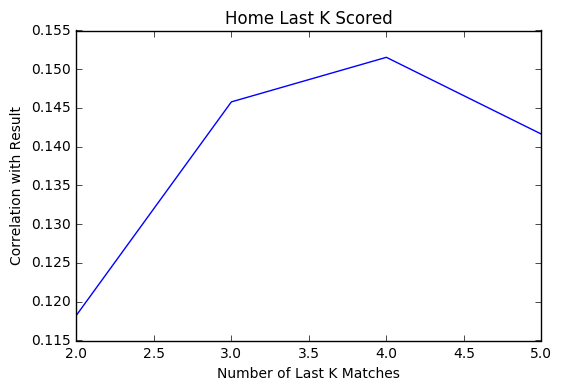

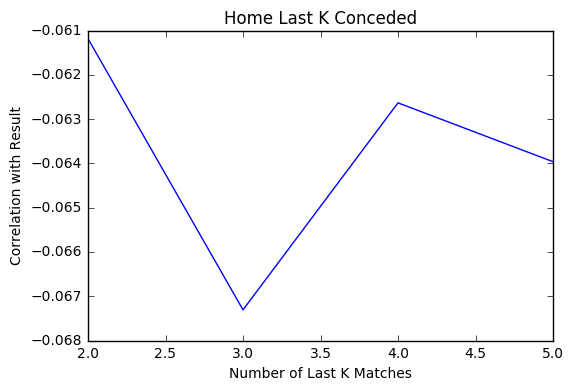

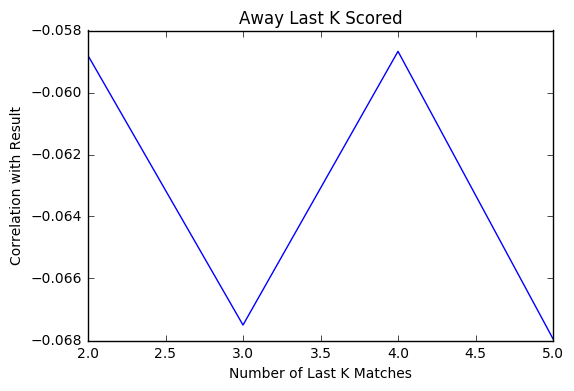

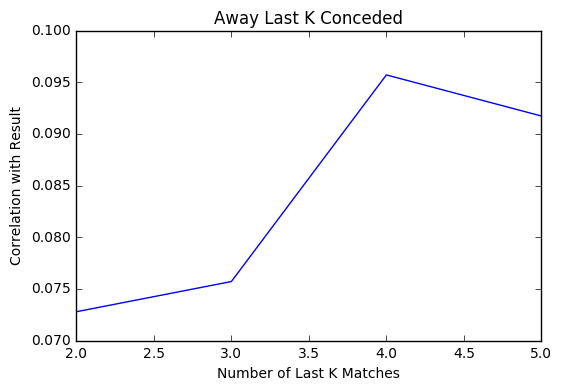

In [111]:
metric_list = ['home_last_%d_scored','home_last_%d_conceded','away_last_%d_scored','away_last_%d_concede']
count = 0
for metric in metric_list:
    corr_list = []
    count +=1
    for i in range(2,6):
        corr_list.append(pearsonr(matches[metric%i],matches['Result_Target'])[0])
    plt.plot(range(2,6),corr_list)
    plt.xlabel('Number of Last K Matches')
    plt.ylabel('Correlation with Result')
    if count == 1:
        plt.title('Home Last K Scored')
    if count == 2:
        plt.title('Home Last K Conceded')
    if count == 3:
        plt.title('Away Last K Scored')
    if count == 4:
        plt.title('Away Last K Conceded')
        
    plt.show()
        

In [121]:
metric_list = ['Home_Promoted_Flag', 'Away_Promoted_Flat','Standing_Diff','Diff_Goal_Diff']
count = 0
corr_list = []
for metric in metric_list:
    corr_list.append(pearsonr(matches[metric],matches['Result_Target'])[0])


In [122]:
print 'Home Promoted Flag Correlation with Target= ' + str(round(corr_list[0],2))
print 'Away Promoted Flag Correlation with Target= ' + str(round(corr_list[1],2))
print 'League Standing Difference Correlation with Target= ' + str(round(corr_list[2],2))
print 'Difference in Goal Diff Correlation with Target= ' + str(round(corr_list[3],2))

Home Promoted Flag Correlation with Target= -0.08
Away Promoted Flag Correlation with Target= 0.08
League Standing Difference Correlation with Target= -0.27
Difference in Goal Diff Correlation with Target= 0.3


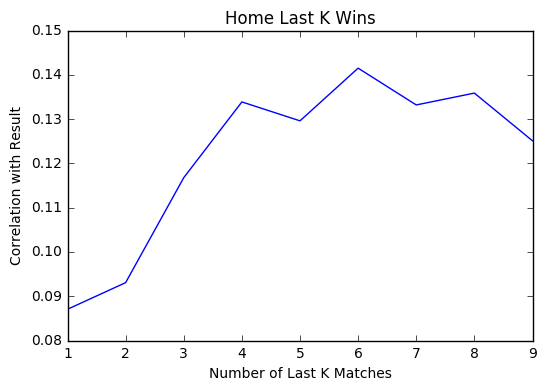

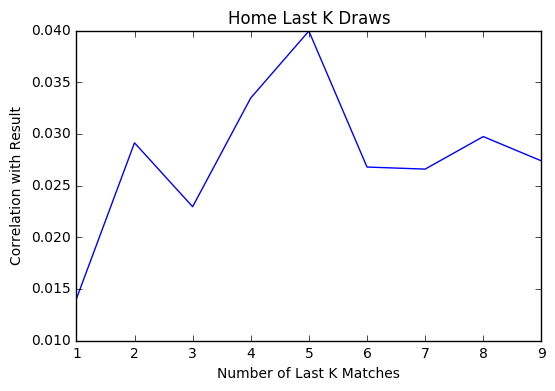

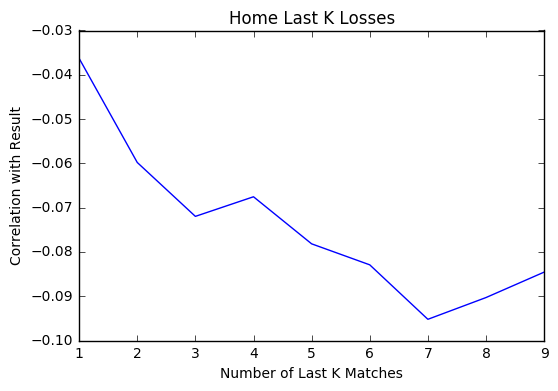

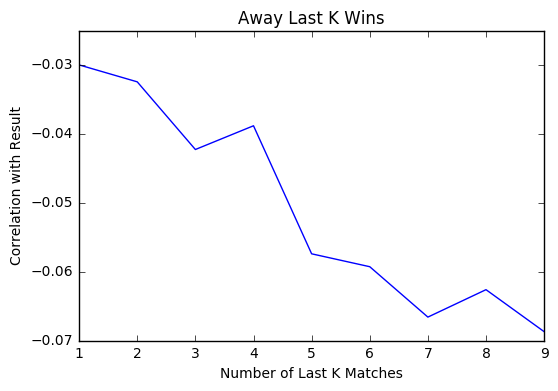

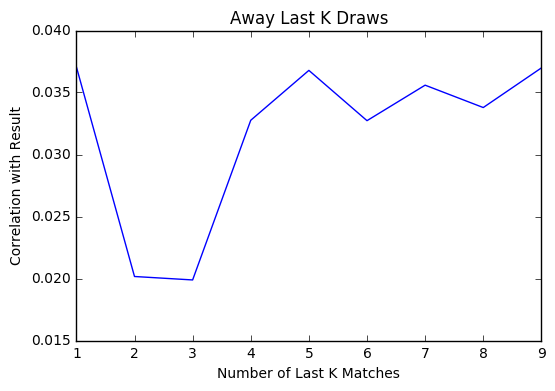

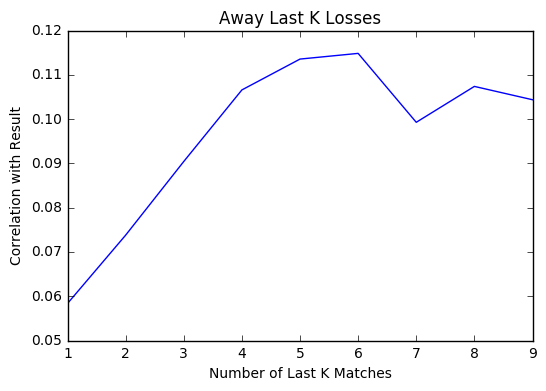

In [118]:
metric_list = ['Home_Team_Last_%d_Wins','Home_Team_Last_%d_Draws','Home_Team_Last_%d_Losses','Away_Team_Last_%d_Wins','Away_Team_Last_%d_Draws','Away_Team_Last_%d_Losses']
count = 0
for metric in metric_list:
    corr_list = []
    count +=1
    for i in range(1,10):
        corr_list.append(pearsonr(matches[metric%i],matches['Result_Target'])[0])
    plt.plot(range(1,10),corr_list)
    plt.xlabel('Number of Last K Matches')
    plt.ylabel('Correlation with Result')
    if count == 1:
        plt.title('Home Last K Wins')
    if count == 2:
        plt.title('Home Last K Draws')
    if count == 3:
        plt.title('Home Last K Losses')
    if count == 4:
        plt.title('Away Last K Wins')
    if count == 5:
        plt.title('Away Last K Draws')
    if count == 6:
        plt.title('Away Last K Losses')               
        
    plt.show()